# Experiments

In [1]:
import torch
import torchvision
from torchvision import models
import time
import networkx as nx
from torch import optim, nn
from importlib import reload
import numpy as np
import pickle

import GPUtil

import sys


## Copy of Inceptionv3, slightly modified for recording intermeridates
sys.path.append('/home/cshetty2/sct/pytorch')
import reformated_models.pytorch_modified_inception as pytorch_modified_inception

## Modified Alexnet, with a'factor' by which it can be made 'fat' 
import simple_model as sm
import dummyModels as dm


## Placer libs of baechi
sys.path.append('/home/cshetty2/sct')
from placer.placer_lib import *

import matplotlib.pyplot as plt

######## For profiler #################
from torch.profiler import profile, record_function, ProfilerActivity

######## For debug purposes ONLY ########
import ctypes, gc
import psutil, os

### From https://discuss.pytorch.org/t/how-pytorch-releases-variable-garbage/7277
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)
#########################################

%matplotlib inline
%load_ext autoreload
%autoreload 2

#############################################################################################


## Defined in this round about way (instead of just directly assigning) to keep it compatibble with summarize.py
class Args:
     def __init__(self,itype, prof_rounds, prof_gpu_id, batch_size, gpu_num, sch):
         self.type = itype
         self.prof_rounds = prof_rounds
         self.prof_gpu_id = prof_gpu_id
         self.batch_size = batch_size
         self.gpu_num = gpu_num
         self.sch = sch
            
itype       = 'forward'  # help: forward/all -> Conside forward path only or both
prof_rounds = 20     # help: 'rounds for profiler'
prof_gpu_id = 0      # help: 'which gpu to place the profiler'
batch_size  = '128'   # help: 'batch_size'
gpu_num     = 4      # help: 'number of gpu to use'
sch         = 'sct'  # help: 'sct/etf/topo'

args = Args(itype, prof_rounds, prof_gpu_id, batch_size, gpu_num, sch)

#############################################################################################
"""
    Function: placer_lib.create_device_graph
    -> Creates a graph with devices as nodes and unit weight edges between them
    -> Each node: graph.add_node(device_id,
                                 id=device_id,
                                 name=device_info["name"],
                                 size=0,
                                 memory_limit=device_info["memory_size"])
"""
DEVICE_GRAPH_SINGLE = create_device_graph({0: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:0', 'memory_size': 17179869184, 'type': ''}})
DEVICE_GRAPH_MULTIPLE = create_device_graph({0: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:0', 'memory_size': 8000000000, 'type': ''}, 
                                             1: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:1', 'memory_size': 8000000000, 'type': ''}, 
                                             2: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:2', 'memory_size': 8000000000, 'type': ''}, 
                                             3: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:3', 'memory_size': 8000000000, 'type': ''}})

#############################################################################################
"""
    we are going to use streams to allow parallel processing
"""
COMPUTE0 = torch.cuda.Stream(device=0)
COMPUTE1 = torch.cuda.Stream(device=1)
COMPUTE2 = torch.cuda.Stream(device=2)
COMPUTE3 = torch.cuda.Stream(device=3)
COMPUTE_STREAM = {0:COMPUTE0,1:COMPUTE1,2:COMPUTE2,3:COMPUTE3}

#############################################################################################


## Print memory of all available GPU's
def print_gpu_memory():
    for i in range(torch.cuda.device_count()):
        #print(torch.cuda.get_device_name(i))
        print("GPU:", i)
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,8), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(i)/1024**3,8), 'GB')
        #print("-----------------")
        #GPUtil.showUtilization()
        print("-----------")

# print memory of given GPU. ex: gpu_no = 0
def print_mem(gpu_id, cached=2, unit='GB'):
    if unit=='GB':
        mem_allocated = round(torch.cuda.memory_allocated(gpu_id)/1024**3,8)
        mem_cached    = round(torch.cuda.memory_reserved(gpu_id)/1024**3,8)
    else:
        mem_allocated = torch.cuda.memory_allocated(gpu_id)
        mem_cached    = torch.cuda.memory_reserved(gpu_id)
        
    if cached>0:
        print('Allocated:', mem_allocated , 'GB')
    if cached>1:
        print('Cached:   ', mem_cached    , 'GB')
    return mem_allocated, mem_cached

#############################################################################################


#### Estimate size of the model (in GB or MB or )

def estimate_model_size(model, unit='MB', to_print = True): 
    persistent_memory = 0
    for name, param in model.named_parameters():
        persistent_memory += param.element_size() * param.nelement()
    if unit == 'GB':
        gb_mem = round(persistent_memory/1024**3,8)
        if to_print:
            print("Estimated Model Memory:",gb_mem, "GB")
        return gb_mem
    elif unit == 'B':
        gb_mem = persistent_memory
        if to_print:
            print("Estimated Model Memory:",gb_mem, "Bytes")
        return gb_mem
    else:
        mb_mem = round(persistent_memory/1024**2,8)
        if to_print:
            print("Estimated Model Memory:", mb_mem, "MB")
        return mb_mem
    
def estimate_input_size(inp, unit='MB'):
    input_size = 0
    if isinstance(inp, torch.Tensor): 
        input_size += float(torch.prod(torch.tensor(inp.size())))
    if isinstance(inp, list): 
        for sub_inp in inp:
            if isinstance(sub_inp, torch.Tensor): input_size += float(torch.prod(torch.tensor(sub_inp.size())))

    input_size = input_size*torch.rand((1,1)).element_size() # multiply by 4
    if unit == 'GB':
        gb_mem = round(input_size/1024**3,8)
        print("Estimated Input Memory:",gb_mem, "GB")
        return gb_mem
    if unit == 'B':
        gb_mem = input_size
        print("Estimated Input Memory:",gb_mem, "B")
        return gb_mem
    else:
        mb_mem = round(input_size/1024**2,8)
        print("Estimated Input Memory:", mb_mem, "MB")
        return mb_mem
    
    
    
def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = {}
    if children == []:
        # if model has no children; model is last child! :O
        return {id(model): model}
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.update(get_children(child))
            except TypeError:
                flatt_children.update(get_children(child))
    return flatt_children

def get_module_list(model):
    module_list = []
    def get_modules(module):
        sub_modules = module.__dict__['_modules']
        if len(sub_modules)>0:
            for name, sub_module in sub_modules.items():
                get_modules(sub_module)
        else:
            module_list.append(module)
    get_modules(model)
    return module_list

print_gpu_memory()


GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


## Basic Setup

### Arguments passed (usually from the command line)

### Device (4 GPU) Setup

### Utilities

In [2]:
## Print memory of all available GPU's
def print_gpu_memory():
    for i in range(torch.cuda.device_count()):
        #print(torch.cuda.get_device_name(i))
        print("GPU:", i)
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,8), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(i)/1024**3,8), 'GB')
        #print("-----------------")
        #GPUtil.showUtilization()
        print("-----------")

# print memory of given GPU. ex: gpu_no = 0
def print_mem(gpu_id, cached=2, unit='GB'):
    if unit=='GB':
        mem_allocated = round(torch.cuda.memory_allocated(gpu_id)/1024**3,8)
        mem_cached    = round(torch.cuda.memory_reserved(gpu_id)/1024**3,8)
    else:
        mem_allocated = torch.cuda.memory_allocated(gpu_id)
        mem_cached    = torch.cuda.memory_reserved(gpu_id)
        
    if cached>0:
        print('Allocated:', mem_allocated , 'GB')
    if cached>1:
        print('Cached:   ', mem_cached    , 'GB')
    return mem_allocated, mem_cached

In [3]:
#### Estimate size of the model (in GB or MB or )

def estimate_model_size(model, unit='MB', to_print = True): 
    persistent_memory = 0
    for name, param in model.named_parameters():
        persistent_memory += param.element_size() * param.nelement()
    if unit == 'GB':
        gb_mem = round(persistent_memory/1024**3,8)
        if to_print:
            print("Estimated Model Memory:",gb_mem, "GB")
        return gb_mem
    elif unit == 'B':
        gb_mem = persistent_memory
        if to_print:
            print("Estimated Model Memory:",gb_mem, "Bytes")
        return gb_mem
    else:
        mb_mem = round(persistent_memory/1024**2,8)
        if to_print:
            print("Estimated Model Memory:", mb_mem, "MB")
        return mb_mem
    
def estimate_input_size(inp, unit='MB'):
    input_size = 0
    if isinstance(inp, torch.Tensor): 
        input_size += float(torch.prod(torch.tensor(inp.size())))
    if isinstance(inp, list): 
        for sub_inp in inp:
            if isinstance(sub_inp, torch.Tensor): input_size += float(torch.prod(torch.tensor(sub_inp.size())))

    input_size = input_size*torch.rand((1,1)).element_size() # multiply by 4
    if unit == 'GB':
        gb_mem = round(input_size/1024**3,8)
        print("Estimated Input Memory:",gb_mem, "GB")
        return gb_mem
    if unit == 'B':
        gb_mem = input_size
        print("Estimated Input Memory:",gb_mem, "B")
        return gb_mem
    else:
        mb_mem = round(input_size/1024**2,8)
        print("Estimated Input Memory:", mb_mem, "MB")
        return mb_mem

In [4]:
# Get the leaf operations in a model. model.modules() gives not just the leaves, bbut higher levels as well
# Ref: https://stackoverflow.com/questions/54846905/pytorch-get-all-layers-of-model
# More explanation: https://discuss.pytorch.org/t/module-children-vs-module-modules/4551/4
def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = {}
    if children == []:
        # if model has no children; model is last child! :O
        return {id(model): model}
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.update(get_children(child))
            except TypeError:
                flatt_children.update(get_children(child))
    return flatt_children

In [5]:
## A global variable can be directly called form inside a function
## But to change it, use the 'global' keyword
## Source: https://stackoverflow.com/questions/10588317/python-function-global-variables
def del_all():
    ## Clear the GPU
    try:
        global model
        del model
    except:
        print("No model")
    try:
        global inp
        del inp
    except:
        print("No inp")
    try:
        global labels
        del labels
    except:
        print("No Labels")
    try:
        global output
        del output
    except:
        print("No Output")
    try:
        global loss
        del loss
    except:
        print("No Loss")
    try:
        global optimizer
        del optimizer
    except:
        print("No optimizer")
    print("Emptying cache")
    torch.cuda.empty_cache()
    print_mem(args.prof_gpu_id)


In [6]:
## For plotting memory trace through a training run.

## (Github: https://github.com/quentinf00/article-memory-log)

from matplotlib import pyplot as plt


def pp(df, exp):
    df_exp = df[df.exp == exp]
    df_pprint = (
        df_exp.assign(
            open_layer=lambda ddf: ddf.hook_type.map(
                lambda x: {"pre": 0, "fwd": 1, "bwd": 2}[x]).rolling(2).apply(lambda x: x[0] == 0 and x[1] == 0
                                                                              )
        )
            .assign(
            close_layer=lambda ddf: ddf.hook_type.map(
                lambda x: {"pre": 0, "fwd": 1, "bwd": 2}[x]).rolling(2).apply(lambda x: x[0] == 1 and x[1] == 1)
        )
            .assign(indent_level=lambda ddf: (ddf.open_layer.cumsum() - ddf.close_layer.cumsum()).fillna(0).map(int))
            .sort_values(by="call_idx")
            .assign(mem_diff=lambda ddf: ddf.mem_all.diff() // 2 ** 20)
    )
    pprint_lines = [
        f"{'    ' * row[1].indent_level}{row[1].layer_type} {row[1].hook_type}  {row[1].mem_diff or ''}"
        for row in df_pprint.iterrows()
    ]
    for x in pprint_lines:
        print(x)


def plot_mem(
        df,
        exps=None,
        normalize_call_idx=True,
        normalize_mem_all=True,
        filter_fwd=False,
        return_df=False,
        output_file=None
):
    if exps is None:
        exps = df.exp.drop_duplicates()

    fig, ax = plt.subplots(figsize=(20, 10))
    for exp in exps:
        df_ = df[df.exp == exp]

        if normalize_call_idx:
            df_.call_idx = df_.call_idx / df_.call_idx.max()

        if normalize_mem_all:
            df_.mem_all = df_.mem_all - df_[df_.call_idx == df_.call_idx.min()].mem_all.iloc[0]
            df_.mem_all = df_.mem_all // 2 ** 20

        if filter_fwd:
            layer_idx = 0
            callidx_stop = df_[(df_["layer_idx"] == layer_idx) & (df_["hook_type"] == "fwd")]["call_idx"].iloc[0]
            df_ = df_[df_["call_idx"] <= callidx_stop]
            # df_ = df_[df_.call_idx < df_[df_.layer_idx=='bwd'].call_idx.min()]

        plot = df_.plot(ax=ax, x='call_idx', y='mem_all', label=exp)
        if output_file:
            plot.get_figure().savefig(output_file)

    if return_df:
        return df_

In [7]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


### Define Submodules of model as nodes

In [8]:
class SubModuleNode:
    """
    This class represents a submodel (ex. conv2d layer) in the given model (ex. inception_v3). 
    It is represented as a node in the return graph
    """
    def __init__(self):
        # store the entire submodel
        self.module = None
        # submodel name
        self.name = None

        # nodes that must finish processing before this node (direct dependencies)
        self.parent = set()
        # nodes that depends on this node
        self.children = set()

        # forward function's estimated runtime
        self.weight_forward = 0
        # backward function's estimated runtime
        self.weight_backward = 0
        # id represented by the model's location (python's id function)
        self.id_hash = None
        # sudo id used, for one model, this sudo id starts from 0 and add 1 for each new node
        self.id = None
        # storage used by submodel's parameters (weight, bias)
        self.persistent_memory = 0
        # submodel's input's size
        self.input_memory = 0
        # submodel's output's size
        self.output_memory = 0
        
        # gpu assigned to the submodule
        self.p = None
       

### Original Profilling Method

Objectives: For a given model:
1) Decompose the model to consituent modules (layers) \
2) Measure steady state forward pass time for each of them \
3) Measure steady state backward pass time for each of them \
4) Measure memory usuage for each of them (input, module parameters, output) \


Functions:

```run```: runs a dry run of training \
&emsp;-```recur_function```: iteratively breaks the model into modules. For each leaf module (those with empty module.__dict__['_modules']), compute its forward completion time, add a forward hook and backward hook, create a SubModule Node and return it \

Problems:

- Memory measurement is measured as the sum of number of parameters. Size factor of 4 (tensor.float32) is missing
- Memory measurement is static. Peak memory usuage due to storing of activations in forward pass not accounted for


In [9]:
class Profiling:
    """
    This class produce the profile, this class referenced "https://github.com/msr-fiddle/pipedream"
    """
    def __init__(self, model, gpu=0, rounds=20, inception=False):
        """
        model: ex. inception_v3 model, alexnet model, etc
        gpu: choose in between {0,1,2,3}
        rounds: number of rounds to run the profiling
        """
        self.gpu = gpu
        self.model = model.to(self.gpu)

        self.rounds = rounds
        # first few rounds are inaccurate, so I choose to discard the results from the first 1/4 rounds
        self.ignore_rounds = int(self.rounds/4)
        # counting variable, runs from 0 - self.rounds
        self.cur_round = 0

        # used to calculate backward runtime for each submodule
        self.back_record = []
        # all submodules record of the form {id_hash: SubModuleNode}
        self.sub_module_nodes = {}
        # use id_hash to record the order of submodules's execution
        self.submodule_order = []

        # internal use only, record the original forward functions for submodules
        self.forward_original_methods = {}
        # internal use only, switch back to the original forward functions after profiling
        self.detach_record = set()
        # Indicates if it is an inception model
        self.inception = inception

    def recur_function(self, module):
        """
        modify self.model: adding forward timing, backward timing, input output sizes, etc
        :param module: the model to recursively add forward/backward wrappers to
        """
        this_profiler = self
        sub_modules = module.__dict__['_modules']
        for name, sub_module in sub_modules.items():
            # sub modules of sub_module, if there are more than 1, we need further recursion
            sub_sub_modules = sub_module.__dict__['_modules']
            if len(sub_sub_modules) > 0:
                self.recur_function(sub_module)
                continue

            def calculate_forward_time(function, *input):
                """
                helper function in forward wrapper
                calculate forward runtime, and submodule result
                """
                torch.cuda.synchronize(self.gpu)
                start_time = time.time()
                result = function(*input)
                torch.cuda.synchronize(self.gpu)
                stop_time = time.time()
                return (stop_time - start_time) * 1000, result

            def forward_wrapper(cur_module, *input):
                """
                use this wrapper to replace the original forward function in submodules
                :param cur_module: the input submodule
                """
                # original forward function
                function = this_profiler.forward_original_methods[cur_module]
                if this_profiler.cur_round < this_profiler.ignore_rounds:
                    if this_profiler.cur_round == 0:
                        # record submodule execution order only in the first round
                        this_profiler.submodule_order.append(id(cur_module))
                    # do not record first few rounds
                    result = function(*input)
                    return result
                
                # collect relevant information of cur module
                forward_time, result = calculate_forward_time(function, *input)
                input_size = 0; persistent_memory = 0; output_memory = 1
                for inp in input:
                    if isinstance(inp, torch.Tensor): input_size += float(torch.prod(torch.tensor(inp.size())))
                    if isinstance(inp, list): 
                        for sub_inp in inp:
                            if isinstance(sub_inp, torch.Tensor): input_size += float(torch.prod(torch.tensor(sub_inp.size())))
                for name, param in cur_module.named_parameters():
                    product = 1
                    for i in param.size(): product *= i
                    persistent_memory += product
                for i in result.size(): output_memory *= i

                # record a SubModuleNode for each model layer
                if id(cur_module) not in this_profiler.sub_module_nodes:
                    cur_node = SubModuleNode()
                    cur_node.id_hash = id(cur_module)
                    cur_node.module = cur_module
                    cur_node.name = cur_module.__class__.__name__
                    cur_node.persistent_memory = persistent_memory
                    cur_node.output_memory = output_memory
                    cur_node.input_memory = input_size
                else:
                    cur_node = this_profiler.sub_module_nodes[id(cur_module)]
                # we want weight_forward as the average forward runtime of the relevent rounds
                cur_node.weight_forward += forward_time / (this_profiler.rounds - this_profiler.ignore_rounds)
                this_profiler.sub_module_nodes[id(cur_module)] = cur_node

                return result

            def hook(cur_module, inputs, output):
                # this is for retriving the module inside make dot function
                output.grad_fn.metadata['module'] = cur_module

            def backward_post_hook(cur_module, input, output):
                """
                add backward hook to record backward runtime
                :param cur_module: the input submodule
                """
                if this_profiler.cur_round < this_profiler.ignore_rounds:
                    # do not record first few rounds
                    return
                torch.cuda.synchronize(0)
                cur_time = time.time() * 1000
                this_profiler.back_record.append((id(cur_module), cur_time))

            if sub_module in self.forward_original_methods:
                # only record the original forward functions once
                continue

            self.forward_original_methods[sub_module] = sub_module.forward
            sub_module.forward = forward_wrapper.__get__(sub_module, sub_module.__class__)
            sub_module.register_forward_hook(hook)
            sub_module.register_backward_hook(backward_post_hook)
            
    def detach(self, module):
        """
        use this helper function to detach all forward wrappers
        """
        this_profiler = self
        sub_modules = module.__dict__['_modules']
        for name, sub_module in sub_modules.items():
            sub_sub_modules = sub_module.__dict__['_modules']
            if len(sub_sub_modules) > 0:
                self.detach(sub_module)
                continue
            if sub_module in self.detach_record:
                continue

            self.detach_record.add(sub_module)
            sub_module.forward = self.forward_original_methods[sub_module]

    def run(self):
        """
        :return: the model's output of the final round
        """
        self.sub_module_nodes = {}
        self.recur_function(self.model)

        # create a fake dataset, we don't care about accuracy.
        dataset = torchvision.datasets.FakeData(
            size=self.rounds * int(args.batch_size),
            image_size=(3, 299, 299),
            num_classes=1000,
            transform=torchvision.transforms.ToTensor())
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=int(args.batch_size))
        # this is the output of the final round
        last_output = None
        for batch_idx, (inp, oup) in enumerate(data_loader):
            self.cur_round = batch_idx
            # clear the record list
            self.back_record = []

            inp = inp.to(self.gpu); inp.requires_grad = True
            optimizer = optim.SGD(self.model.parameters(), lr = 0.0001); optimizer.zero_grad()
            criterion = nn.MSELoss()

            torch.cuda.synchronize(self.gpu)
            output = self.model(inp)
            torch.cuda.synchronize(self.gpu)

            ## the following two lines only apply to inception_v3 model
            if (self.inception):
                output = output.logits[0] + output.aux_logits[0]
                loss = criterion(output, torch.randn(len(output)).to(self.gpu))
            else: ## if the model is not inception_v3, use the following one line
                loss = criterion(output, torch.randn(int(args.batch_size), len(output[0])).to(self.gpu))
            
            
            
            # add the start time of backward 
            self.back_record.append(('start', time.time() * 1000))
            if batch_idx == self.rounds - 1:
                loss.backward(loss, retain_graph=True)
                last_output = output
            else:
                loss.backward(loss)

            if batch_idx < self.ignore_rounds:
                continue
            else:
                # calculate the backward runtime for each layer by calculating the time differences between each timestamp
                for i in range(len(self.back_record) - 1, 0, -1):
                    now = self.back_record[i]
                    prev = self.back_record[i - 1]
                    cur_node = self.sub_module_nodes[now[0]]
                    cur_node.weight_backward += (now[1] - prev[1]) / (self.rounds - self.ignore_rounds)
                    self.sub_module_nodes[now[0]] = cur_node
        self.detach(self.model)
        return last_output
    

## \*\*\*\*\*\*Test - Profiling:**\*\*\*\***

### Forward Time Tests

- Measure the time for forward pass through a module.
- Verify that forward pass time through entire model is sum of individual forward passes
- All tests done on single GPU. No communication costs involved

In [5]:
#### LOAD MODEL & INPUTS INTO THE GPU

factorModel = 1  # Factor by which size of layers (i.eno of params) in the model is scaled
inp_size = (32, 3, 299, 299)

to_gpu = 1 # to use GPU or CPU?
which_model = 'toyToyModel'

if which_model == 'toyModel':
    model = sm.toyModel(factor=factorModel)
elif which_model == 'toyToyModel':
    model = sm.toyToyModel(factor=factorModel)
else:
    print("Invalid model name")
    
inp   = torch.rand(inp_size)

if to_gpu:
    model = model.to(args.prof_gpu_id)
    inp   = inp.to(args.prof_gpu_id)

In [6]:
prof_gpu = args.prof_gpu_id

def _calculate_forward_time(function, *input):
    """
    helper function in forward wrapper
    calculate forward runtime, and submodule result
    """
    torch.cuda.synchronize(prof_gpu)
    start_time = time.time()
    result = function(*input)
    torch.cuda.synchronize(prof_gpu) # need to sync before measuring time
    stop_time = time.time()
    return (stop_time - start_time) * 1000, result

In [7]:
## Check forward times for some layers individually
if which_model == 'toyModel':
    #Conv2D
    sub_module = model.__dict__['_modules']['features'].__dict__['_modules']['0']
    forward_time0, result0 = _calculate_forward_time(sub_module.forward,inp)

    #ReLU
    sub_module = model.__dict__['_modules']['features'].__dict__['_modules']['1']
    forward_time1, result1 = _calculate_forward_time(sub_module.forward,inp)


    print ("Conv2d layer forward time:", forward_time0)
    print ("ReLU layer forward time:", forward_time1)
    print()
    
# Total time for 'sequential'
    forward_times =[]
    result = inp
    for name, sub_module in model.__dict__['_modules']['features'].__dict__['_modules'].items():
        forward_time, result = _calculate_forward_time(sub_module.forward,result)
        forward_times.append(forward_time)

    print ("Sum of individual forwards:")
    print (sum(forward_times)) 


    module = model.__dict__['_modules']['features']
    forward_time, result = _calculate_forward_time(module.forward,inp)

    print("Net forward")
    print (forward_time)

    # Verfied _calculate_forward_time works
else:
    print("Use the toyModel for this part")

Use the toyModel for this part


In [8]:
### Main TEST: Check sum of computed forward times is equal to net forward time
### Ensures there are no hidden operations when layers are chained together
forward_times =[]
result = inp
for sub_module_id, sub_module in get_children(model).items():
    if isinstance(sub_module, nn.Linear):
        result = torch.flatten(result, 1)
    forward_time, result = _calculate_forward_time(sub_module.forward,result)
    forward_times.append(forward_time)

print ("Sum of individual forwards:")
print (sum(forward_times)) 


forward_time, result = _calculate_forward_time(model.forward,inp)

print("Net forward")
print (forward_time)

# Verfied _calculate_forward_time works

Sum of individual forwards:
7.464885711669922
Net forward
2.548694610595703


/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
forward_times

[4.520654678344727,
 0.5884170532226562,
 1.0364055633544922,
 0.2651214599609375,
 0.6837844848632812,
 0.2758502960205078,
 0.09465217590332031]

In [10]:
try:
    del result0
except:
    pass
try:
    del result1
except:
    pass
try:
    del sub_module
except:
    pass
try:
    del result
except:
    pass
try:
    del module
except:
    pass
del_all()

NameError: name 'del_all' is not defined

### Object Memory estimation tests

In [ ]:
## Clear the GPU
del_all()

In [ ]:
## Compute actual on-GPU memory of model and the input

factorModel = 1
inp_size = (1, 3, 2990, 2990)

print("Before starting.......\n")
mem_allocated0, mem_cached0 = print_mem(args.prof_gpu_id)

print("\nOn Moving model to GPU....\n")
model = sm.toyModel(factor=factorModel).to(args.prof_gpu_id)
mem_allocated1, mem_cached1 = print_mem(args.prof_gpu_id)

print("\nOn Moving Input to GPU....\n")
inp = torch.rand(inp_size).to(args.prof_gpu_id)
mem_allocated2, mem_cached2 = print_mem(args.prof_gpu_id)

model_actual_memory = round(mem_allocated1 - mem_allocated0, 10)
input_actual_memory = round(mem_allocated2 - mem_allocated1, 10)

print()
print("Actual model memory: ", model_actual_memory)
print("Actual Input memory: ", input_actual_memory)

In [ ]:
## Current memory computation is off by a factor of 4 (i.e size tensor.float32)
## Just multiply the number of parameters in the sub_module result by 4

input_size = 0
if isinstance(inp, torch.Tensor): 
    input_size += float(torch.prod(torch.tensor(inp.size())))
if isinstance(inp, list): 
    for sub_inp in inp:
        if isinstance(sub_inp, torch.Tensor): input_size += float(torch.prod(torch.tensor(sub_inp.size())))

input_size = input_size*torch.rand((1,1)).element_size() # multiply by 4

print("Estimated Input memory: ", round(input_size/1024**3,4), "GB")
print("Actual Input memory   : ", input_actual_memory, "GB", "\n")


## Correct way - Model memory
persistent_memory = 0
for name, param in model.named_parameters():
    persistent_memory += param.element_size() * param.nelement()

print("Estimated Model Memory:",round(persistent_memory/1024**3,4), "GB")
print("Actual model memory   :",model_actual_memory, "GB")


In [ ]:
## Clear the GPU
print_gpu_memory()
del_all()

### Memory changes in forward and backward passes

In [10]:
### Step through the training process and note the memory changes at each step

##----------------STEPS TO RUN---------------------------------
## steps_to_run options
## 0 -> Load model and input
## 1 -> Run Forward
## 2 -> Move labels and Compute loss
## 3 -> Backward Run
## 4 -> Run Update Step
## 5 -> Delete all intermediates
steps_to_run = 4
reload_model = 0 #indicates to not reload model and inputs if already loaded
##--------------------------------------------------------------

loaded = 0       # flag to indicate if model and inputs are already loaded

In [11]:

print("Initial State:")
mem_allocated, mem_cached = print_mem(args.prof_gpu_id)
print()

# Load Model and Input
if (steps_to_run >= 0) and (loaded==0):
    print("Loading the Model and input")
    factorModel = 1  # Factor by which size of layers (i.eno of params) in the model is scaled
    
    ################################################################################
    inp_size = (32, 3, 299, 299)
    model = sm.toyToyModel(factor=factorModel).to(args.prof_gpu_id)
    #model = sm.toyModel(factor=factorModel).to(args.prof_gpu_id)
    
    #inp_size = (1, 10000)
    #model = sm.linearModel(factor=factorModel).to(args.prof_gpu_id)
    ################################################################################
    
    inp   = torch.rand(inp_size).to(args.prof_gpu_id)
    
    inp.requires_grad = False # Usually you don’t need gradients in your input. 
                              # However, gradients in the input might be needed for some 
                              # special use cases e.g. creating adversarial samples.
    
    
    torch.cuda.synchronize(args.prof_gpu_id)
    mem_allocated0a, mem_cached0a = print_mem(args.prof_gpu_id)
    print("Difference: ", mem_allocated0a-mem_allocated, "GB \n")

    #--------------------TRAINING STEPS-----------------------------
    print("Loading the optimizer")
    
    optimizer = optim.SGD(model.parameters(), lr = 0.0001); 
    optimizer.zero_grad()
    
    torch.cuda.synchronize(args.prof_gpu_id)
    mem_allocated0b, mem_cached0b = print_mem(args.prof_gpu_id)
    print("Difference: ", mem_allocated0b-mem_allocated0a, "GB \n") 
    
    criterion = nn.MSELoss()
    
    if reload_model == 0:
        loaded = 1
elif (loaded==1):
    print("Model already loaded!")
    inp   = torch.rand(inp_size).to(args.prof_gpu_id)
    
print("Net setup memory cost")
torch.cuda.synchronize(args.prof_gpu_id)
mem_allocated0, mem_cached0 = print_mem(args.prof_gpu_id)
print("Difference: ", mem_allocated0-mem_allocated, "GB\n")
print("Estimated net memory:", estimate_model_size(model, 'GB') + estimate_input_size(inp, 'GB')) 
print("**************************************************************** \n")

##-----------------ACTUAL RUN----------------------------------
if steps_to_run >= 1:
    print("1) Forward Run: Output generated")
    #model.zero_grad(set_to_none=True)
    output = model(inp)

    output_size = 0
    if isinstance(output, torch.Tensor): 
        output_size += float(torch.prod(torch.tensor(output.size())))
    output_size = output_size*4
    print("Estimated Output Size: ", round(output_size/1024**3,10), "GB" )

    torch.cuda.synchronize(args.prof_gpu_id)
    mem_allocated1, mem_cached1 = print_mem(args.prof_gpu_id)
    print("Difference: ", mem_allocated1-mem_allocated0, "GB")
    print("**************************************************************** \n")

#-------------------------------------------------
if steps_to_run >= 2:
    print("2) Labels moved:")
    labels = torch.randn(output.size()).to(args.prof_gpu_id)

    torch.cuda.synchronize(args.prof_gpu_id)
    mem_allocated2, mem_cached2 = print_mem(args.prof_gpu_id)
    print("Difference: ", mem_allocated2-mem_allocated1, "GB")
    print("**************************************************************** \n")

#-------------------------------------------------
if steps_to_run >= 2:
    print("3) Loss Computed:")
    loss = criterion(output, labels)

    torch.cuda.synchronize(args.prof_gpu_id)
    mem_allocated3, mem_cached3 = print_mem(args.prof_gpu_id)
    print("Difference: ", mem_allocated3-mem_allocated2, "GB")
    print("**************************************************************** \n")

#-------------------------------------------------
if steps_to_run >= 3:
    print("4) Backward Run:")
    loss.backward(loss)

    torch.cuda.synchronize(args.prof_gpu_id)
    mem_allocated4, mem_cached4 = print_mem(args.prof_gpu_id)
    print("Difference: ", mem_allocated4-mem_allocated3, "GB")
    print("**************************************************************** \n")

#-------------------------------------------------
if steps_to_run >= 4:
    print("5) Step & Clear Gradients:")
    optimizer.step()
    
    model.zero_grad(set_to_none=True)
    ##****zero_grad is same as this:****
    #for param in model.parameters():
    #    param.grad = None

    torch.cuda.synchronize(args.prof_gpu_id)
    mem_allocated5, mem_cached5 = print_mem(args.prof_gpu_id)
    print("Difference: ", mem_allocated5-mem_allocated4, "GB")
    print("**************************************************************** \n")

#-------------------------------------------------
if steps_to_run >= 5:
    print("6) Delete Intermediates:")
    del loss
    del output

    torch.cuda.synchronize(args.prof_gpu_id)
    mem_allocated6, mem_cached6 = print_mem(args.prof_gpu_id)
    print("Difference: ", mem_allocated6-mem_allocated5, "GB")
    print("**************************************************************** \n")

Initial State:
Allocated: 0.0 GB
Cached:    0.0 GB

Loading the Model and input
Allocated: 0.11900806 GB
Cached:    0.1328125 GB
Difference:  0.11900806 GB 

Loading the optimizer
Allocated: 0.11900806 GB
Cached:    0.1328125 GB
Difference:  0.0 GB 

Net setup memory cost
Allocated: 0.11900806 GB
Cached:    0.1328125 GB
Difference:  0.11900806 GB

Estimated Model Memory: 0.08666888 GB
Estimated Input Memory: 0.03197229 GB
Estimated net memory: 0.11864117
**************************************************************** 

1) Forward Run: Output generated
Estimated Output Size:  0.0001192093 GB
Allocated: 0.23424721 GB
Cached:    0.24023438 GB
Difference:  0.11523915000000001 GB
**************************************************************** 

2) Labels moved:
Allocated: 0.23436642 GB
Cached:    0.24023438 GB
Difference:  0.00011920999999998072 GB
**************************************************************** 

3) Loss Computed:
Allocated: 0.23436689 GB
Cached:    0.24023438 GB
Differe

/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
## Clear the GPU
### Note: If the optimizer is not defined, then del model, del inp will clear the GPU
### However if optimizer is defined, the memory will still be occupied after del model, del inp
### To clear the mem, you also need del optimizer (which is done inside del_all())

print_gpu_memory()
del_all()

GPU: 0
Memory Usage:
Allocated: 0.11924696 GB
Cached:    0.3828125 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
Emptying cache
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
del_all()

#### Layer-wise memory trace

In [ ]:
del_all()

In [13]:
## Main: Tracking the memory through training
## Modified from: https://www.sicara.ai/blog/2019-28-10-deep-learning-memory-usage-and-pytorch-optimization-tricks
## (Github: https://github.com/quentinf00/article-memory-log)

def _get_gpu_mem(synchronize=True, empty_cache=True):
    return torch.cuda.memory_allocated(), torch.cuda.memory_reserved()


def _generate_mem_hook(handle_ref, mem, idx, hook_type, exp):
    def hook(self, *args):
        if len(mem) == 0 or mem[-1]["exp"] != exp:
            call_idx = 0
        else:
            call_idx = mem[-1]["call_idx"] + 1
        mem_all, mem_cached = _get_gpu_mem()
        torch.cuda.synchronize()
        mem.append({
            'layer_idx': idx,
            'call_idx': call_idx,
            'layer_type': type(self).__name__,
            'exp': exp,
            'hook_type': hook_type,
            'mem_all': mem_all,
            'mem_cached': mem_cached,
        })

    return hook


def _add_memory_hooks(idx, mod, mem_log, exp, hr):

    h = mod.register_forward_pre_hook(_generate_mem_hook(hr, mem_log, idx, 'pre', exp))
    hr.append(h)

    h = mod.register_forward_hook(_generate_mem_hook(hr, mem_log, idx, 'fwd', exp))
    hr.append(h)

    h = mod.register_backward_hook(_generate_mem_hook(hr, mem_log, idx, 'bwd', exp))
    hr.append(h)

def log_mem(model, inp, mem_log=None, exp=None):
    mem_log = []
    exp = exp or f'exp_{len(mem_log)}'
    hr = []
    
    children_list = get_children(model)
    idx = 0
    for module_id, module in children_list.items():
        idx = idx +1
        _add_memory_hooks(idx, module, mem_log, exp, hr)

    try:
        #--------------------TRAINING STEPS-----------------------------
        mem_allocated0, mem_cached0 = print_mem(args.prof_gpu_id)
        print()

        optimizer = optim.SGD(model.parameters(), lr = 0.0001); optimizer.zero_grad()
        criterion = nn.MSELoss()

        #-------------------------------------------------
        print("1) Forward Run: Output generated")
        output = model(inp)

        torch.cuda.synchronize(args.prof_gpu_id)
        mem_allocated1, mem_cached1 = print_mem(args.prof_gpu_id)
        print("Difference: ", mem_allocated1-mem_allocated0, "GB \n")

        #-------------------------------------------------
        print("2) Labels moved:")
        labels = torch.randn(output.size()).to(args.prof_gpu_id)

        torch.cuda.synchronize(args.prof_gpu_id)
        mem_allocated2, mem_cached2 = print_mem(args.prof_gpu_id)
        print("Difference: ", mem_allocated2-mem_allocated1, "GB \n")

        #-------------------------------------------------
        print("3) Loss Computed:")
        loss = criterion(output, labels)

        torch.cuda.synchronize(args.prof_gpu_id)
        mem_allocated3, mem_cached3 = print_mem(args.prof_gpu_id)
        print("Difference: ", mem_allocated3-mem_allocated2, "GB \n")

        #-------------------------------------------------
        print("4) Backward Run:")
        loss.backward(loss)

        torch.cuda.synchronize(args.prof_gpu_id)
        mem_allocated4, mem_cached4 = print_mem(args.prof_gpu_id)
        print("Difference: ", mem_allocated4-mem_allocated3, "GB \n")

        #-------------------------------------------------
        print("5) Step:")
        optimizer.step()
        model.zero_grad(set_to_none=True)

        torch.cuda.synchronize(args.prof_gpu_id)
        mem_allocated5, mem_cached5 = print_mem(args.prof_gpu_id)
        print("Difference: ", mem_allocated5-mem_allocated4, "GB \n")
    finally:
        [h.remove() for h in hr]

        return mem_log
    

In [14]:
# %% Analysis baseline

factorModel = 1
batch_size = 32
inp_size = (batch_size, 3, 299, 299)
#inp_size =(1, 3, 600, 600)

###****************Choose the MODEL************************************
#model = sm.toyToyModel(factor=factorModel).to(args.prof_gpu_id)
model = sm.toyModel(factor=factorModel).to(args.prof_gpu_id)


#model = sm.linearModel(factor=factorModel).to(args.prof_gpu_id)
#inp_size = (1,10000)
###********************************************************************
inp = torch.rand(inp_size).to(args.prof_gpu_id)

#****************************WHY?
# inp.requires_grad = True
#******************************

mem_log = []

try:
    mem_log.extend(log_mem(model, inp,  exp='baseline'))
except Exception as e:
    print(f'log_mem failed because of {e}')

Allocated: 0.2164669 GB
Cached:    0.22265625 GB

1) Forward Run: Output generated
Allocated: 0.41208172 GB
Cached:    0.46875 GB
Difference:  0.19561482 GB 

2) Labels moved:
Allocated: 0.41220093 GB
Cached:    0.46875 GB
Difference:  0.00011921000000003623 GB 

3) Loss Computed:
Allocated: 0.4122014 GB
Cached:    0.46875 GB
Difference:  4.6999999997465736e-07 GB 

4) Backward Run:
Allocated: 0.40124607 GB
Cached:    0.75976562 GB
Difference:  -0.010955329999999985 GB 

5) Step:
Allocated: 0.2167058 GB
Cached:    0.75976562 GB
Difference:  -0.18454027 GB 



/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [15]:
mem_log

[{'layer_idx': 1,
  'call_idx': 0,
  'layer_type': 'Conv2d',
  'exp': 'baseline',
  'hook_type': 'pre',
  'mem_all': 232429568,
  'mem_cached': 239075328},
 {'layer_idx': 1,
  'call_idx': 1,
  'layer_type': 'Conv2d',
  'exp': 'baseline',
  'hook_type': 'fwd',
  'mem_all': 277288960,
  'mem_cached': 285212672},
 {'layer_idx': 2,
  'call_idx': 2,
  'layer_type': 'ReLU',
  'exp': 'baseline',
  'hook_type': 'pre',
  'mem_all': 277288960,
  'mem_cached': 285212672},
 {'layer_idx': 2,
  'call_idx': 3,
  'layer_type': 'ReLU',
  'exp': 'baseline',
  'hook_type': 'fwd',
  'mem_all': 322148352,
  'mem_cached': 331350016},
 {'layer_idx': 3,
  'call_idx': 4,
  'layer_type': 'MaxPool2d',
  'exp': 'baseline',
  'hook_type': 'pre',
  'mem_all': 322148352,
  'mem_cached': 331350016},
 {'layer_idx': 3,
  'call_idx': 5,
  'layer_type': 'MaxPool2d',
  'exp': 'baseline',
  'hook_type': 'fwd',
  'mem_all': 353998848,
  'mem_cached': 367001600},
 {'layer_idx': 4,
  'call_idx': 6,
  'layer_type': 'Conv2d',
 

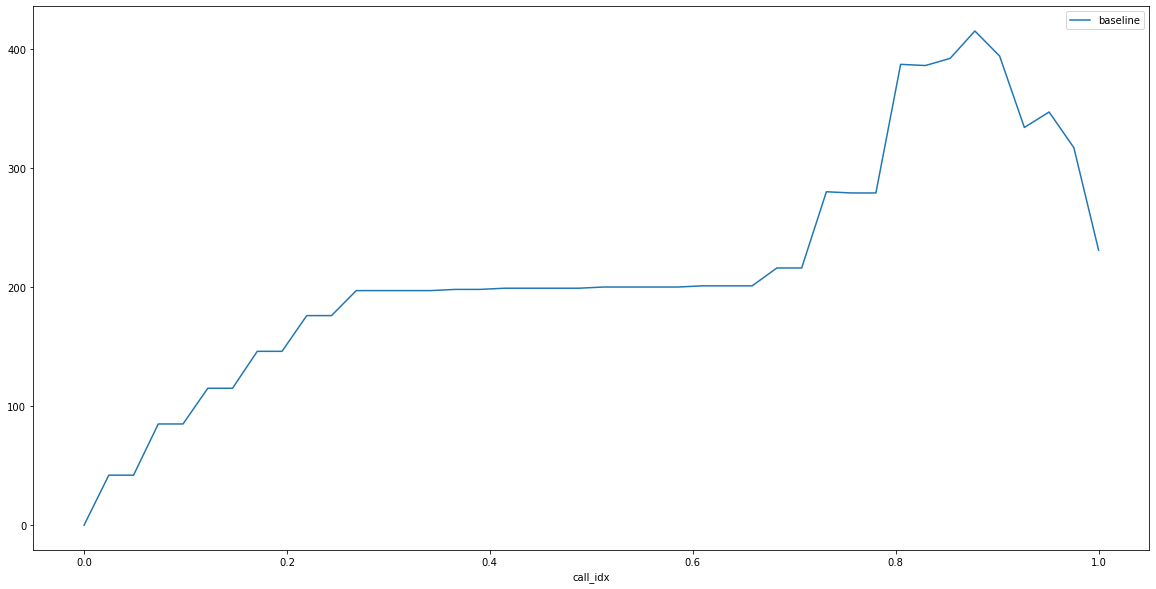

In [16]:
import pandas as pd
df = pd.DataFrame(mem_log)
plot_mem(df, exps=['baseline'])

In [ ]:
print_gpu_memory()
del_all()

### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [ ]:
##################################################################################
def b2gb(x): return round(x/2**30,8)
class TorchTracemalloc():

    def __enter__(self):
        self.begin = torch.cuda.memory_allocated()
        torch.cuda.reset_max_memory_allocated() # reset the peak gauge to zero
        return self

    def __exit__(self, *exc):
        self.end  = torch.cuda.memory_allocated()
        self.peak = torch.cuda.max_memory_allocated()
        self.used   = b2gb(self.end-self.begin)
        self.peaked = b2gb(self.peak-self.begin)
        print(f"delta used/peak {self.used}/{self.peaked}")

###################################################################################

#with torch.no_grad():
if 1:
    initial_mem, _ =print_mem(0, 0)

    batch_size = 30
    inp_size = (batch_size, 3, 299, 299)
    inp = torch.rand(inp_size).to(args.prof_gpu_id)
    input_mem, _ = print_mem(0, 0)

    convLayer1 = nn.Conv2d(3, 64*2, 5).to(args.prof_gpu_id)
    convLayer2 = nn.Conv2d(64*2, 10, 3).to(args.prof_gpu_id)
    convLayer1.requires_grad = True
    convLayer2.requires_grad = True
    mem_setup,_ = print_mem(0, 0)

    print("Input mem size:", input_mem-initial_mem)
    print("Conv layer mem size:", mem_setup-input_mem)
    print("Net setup size:", mem_setup)

    with TorchTracemalloc() as tt:
        out1 = convLayer1(inp)
        out2 = convLayer2(out1)
        #print(mem_setup + b2gb(sys.getsizeof(out.storage())))
    print(tt.peaked - tt.used)

    after_forward,_ = print_mem(0, 0)
    print("After forward pass: ", after_forward)

    print("Size of out:", b2gb(sys.getsizeof(out1.storage())) + b2gb(sys.getsizeof(out2.storage())))

    del out1
    del out2
    after_del_output,_ = print_mem(0, 0)
    print("After deleteing output: ", after_del_output)


    print(after_forward - after_del_output)

In [ ]:
try:
    del convLayer1, convLayer2
except:
    pass
try:
    del out1, out2
except:
    pass

del_all()
#print_mem(0)

#### GPU allocates memory in steps of 512 Bytes

### Peak and used memory in forward and backward passes

In [ ]:
def b2gb(x): return round(x/2**30,8)
class TorchTracemalloc():

    def __enter__(self):
        self.begin = torch.cuda.memory_allocated()
        torch.cuda.reset_max_memory_allocated() # reset the peak gauge to zero
        return self

    def __exit__(self, *exc):
        self.end  = torch.cuda.memory_allocated()
        self.peak = torch.cuda.max_memory_allocated()
        self.used   = (self.end-self.begin)
        self.peaked = (self.peak-self.begin)
        print(f"delta used/peak {self.used}/{self.peaked}")


In [ ]:
def del_temp():
    try:
        del fc1, fc2, fc3
    except:
        pass
    try:
        del inp
    except:
        pass
    try:
        del out
    except:
        pass
    try:
        del target
    except:
        pass
    try:
        del err
    except:
        pass

In [ ]:
## Ensure all variables have been deleted (as below) before running

del_temp()
## Note: All memory size values in output will be rounded to 
## nearest multiple of 512 as demoed in the example above

print("Model Setup")
N   = 50
with TorchTracemalloc() as tt:
    fc1 = nn.Linear(N, 1000).to('cuda:0') # 1000*N*4 (4 is size of float32) =1000*50*4 = 200,000 
    fc2 = nn.Linear(1000, 1000).to('cuda:0') #1000*1000*4 = 4,000,000
    fc3 = nn.Linear(1000, 1000).to('cuda:0') #1000*1000*4 = 4,000,000

print("\nInput Setup")
inp_size = (1, N)
with TorchTracemalloc() as tt:
    inp = torch.rand(inp_size).to('cuda:0') #50*4 = 200

print("\nForward")
with TorchTracemalloc() as tt:
    #with torch.no_grad():
    if 1:
        out = fc3(fc2(fc1(inp))) 
'''
    Each stage:
    fc1 output = 1000*4 = 4000
    Same for fc2, fc3
    
    With grad i.e saving intermediates:
    used_mem = peak_mem = 4000*3 = 12000
    
    Without grad
    used_mem = 4000 (only final out)
    peak_mem = 4000+4000 (Each stage computation involves 4000 at input and 4000 at ouput)
    
'''
        
print("\nLabels Moved")
with TorchTracemalloc() as tt:
    target = torch.rand((1,1000)).to('cuda:0') #4*1000=4000

print("\nLoss Computed")
with TorchTracemalloc() as tt:
    loss_fn = nn.MSELoss()  
    err = loss_fn(out, target)

print("\nBackward")
with TorchTracemalloc() as tt:
    err.backward()  
# Memory doubles 
# used_mem = peak_mem = size of all trainable paremeters

print("\nClear Gradients")
with TorchTracemalloc() as tt:
    fc1.zero_grad(set_to_none=True)
    fc2.zero_grad(set_to_none=True)
    fc3.zero_grad(set_to_none=True)

In [ ]:
N = 50
inp_size = (1, N)
fc1 = nn.Linear(N, 1000).to('cuda:0') 
fc2 = nn.Linear(1000, 1000).to('cuda:0')
fc3 = nn.Linear(1000, 1000).to('cuda:0')

target = torch.rand((1,1000)).to('cuda:0')
loss_fn = nn.MSELoss()

forward_times =[]
backward_times =[]

for _ in range(20):
    inp = torch.rand(inp_size).to('cuda:0')
    out = fc3(fc2(fc1(inp)))
    err = loss_fn(out, target)
    err.backward()
    
for _ in range(100):
    inp = torch.rand(inp_size).to('cuda:0')
    
    start_time = time.time()
    out = fc3(fc2(fc1(inp)))
    stop_time = time.time()
    forward_times.append(stop_time-start_time)
    
    err = loss_fn(out, target)
    
    start_time = time.time()
    err.backward()
    stop_time = time.time()
    backward_times.append(stop_time-start_time)
    
print("Forward times mean: ", np.mean(forward_times))
print("Backward times mean: ", np.mean(backward_times))

#### Froward function modification to track time and memory requirements

In [ ]:
def b2gb(x): return round(x/2**30,8)
class TorchTracemalloc():

    def __enter__(self):
        self.begin = torch.cuda.memory_allocated()
        torch.cuda.reset_max_memory_allocated() # reset the peak gauge to zero
        return self

    def __exit__(self, *exc):
        self.end  = torch.cuda.memory_allocated()
        self.peak = torch.cuda.max_memory_allocated()
        self.used   = (self.end-self.begin)
        self.peaked = (self.peak-self.begin)


def _calculate_time(function, *input):
    torch.cuda.synchronize('cuda:0')
    start_time = time.time()
    result = function(*input)
    torch.cuda.synchronize('cuda:0')
    stop_time = time.time()
    return (stop_time - start_time) * 1000, result

def _calculate_memory(function, *input):
    with TorchTracemalloc() as tt:
        torch.cuda.synchronize('cuda:0')
        start_time = time.time()
        result = function(*input)
        torch.cuda.synchronize('cuda:0')
        stop_time = time.time()
    return (stop_time - start_time) * 1000, tt.used, tt.peaked , result

def fwd_wrapper(module, *input):
    # dummy run
    t, _ = _calculate_time(old_fwd, *input)
    # Actual run
    t_mem, used_mem, peak_mem, res = _calculate_memory(old_fwd, *input)
    t, _ = _calculate_time(old_fwd, *input)
    return t, t_mem, used_mem, peak_mem, res


def _get_metrics(module, inp_size):
    runtime =[]
    mem_measurement_timeOverhead = []
    # achieveing steady state
    for _ in range(20):
        inp = torch.rand(inp_size).to('cuda:0')
        module(inp)
    # Actual Runs
    for _ in range(100):
        inp = torch.rand(inp_size).to('cuda:0')
        t, t_mem, used_mem, peak_mem, _ = module(inp)
        runtime.append(t)
        mem_measurement_timeOverhead.append(t_mem)

   
    print("***********************************")
    print("Mean Runtime:", np.mean(runtime))
    print("STD Runtime:", np.std(runtime))
    print("***********************************")
    print("Mean Runtime with memory measurement:", np.mean(mem_measurement_timeOverhead))
    print("Difference in percent:", 100*(np.mean(mem_measurement_timeOverhead)-np.mean(runtime))/np.mean(runtime), "%")
    print("***********************************")
    print("Used Memory:",used_mem )
    print("Peak Memory:", peak_mem)

# Linear Layer
N = 50
fc1 = nn.Linear(N, 1000).to('cuda:0')
old_fwd = fc1.forward
fc1.forward = fwd_wrapper.__get__(fc1, fc1.__class__)
print("Linear layer:")
_get_metrics(fc1, (1,N))


conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2).to('cuda:0')
old_fwd = conv1.forward
conv1.forward = fwd_wrapper.__get__(conv1, conv1.__class__)
print("\n\nConv layer:")
_get_metrics(conv1, (1, 3, 299, 299))


'''
    1.'Peak memory' maybe different than 'used memory' based on the layer
      Eg: Linear layer they are same, but not in conv
      
    2. No significant overhead in measuring the memory usage 
       using torch.cuda.max_memory_allocated(). So time and memory
       usuage can be measured in the same turn.
       
'''
print("\nDone")

#### Check 'used memory' is indeed output memory size for single layers

In [ ]:
## For Conv layer

m0, _  = print_mem(0,0)
conv2 = nn.Conv2d(3, 640, kernel_size=11, stride=4, padding=2).to('cuda:0')
m1, _  = print_mem(0,0)

print("Actual model mem: ", m1-m0)
estimate_model_size(conv2, 'GB\n')

inp = torch.rand((1, 3, 2990, 2990)).to('cuda:0')
m2, _  = print_mem(0,0)

print("Actual input mem: ", m2-m1)
estimate_input_size(inp, 'GB\n')

with TorchTracemalloc() as tt:
    output = conv2(inp)
print(tt.used, tt.peaked)
out_size = estimate_input_size(output, 'B\n')

## Assert that output size is indeed 
assert (tt.used==512*np.ceil(out_size/512)) # since memory is allotted in blocks of 512B
print("Peak and used difference:", tt.peaked - tt.used)

In [ ]:
del output
del conv2
del inp
print_gpu_memory()

In [ ]:
## For linear layer
m0, _  = print_mem(0,0)
N = 50000
fc1 = nn.Linear(N, 1000).to('cuda:0')
m1, _  = print_mem(0,0)

print("Actual model mem: ", m1-m0)
estimate_model_size(fc1, 'GB\n')

inp = torch.rand((1,N)).to('cuda:0')
m2, _  = print_mem(0,0)

print("Actual input mem: ", m2-m1)
estimate_input_size(inp, 'GB\n')

with TorchTracemalloc() as tt:
    output = fc1(inp)
print(tt.used, tt.peaked)
out_size = estimate_input_size(output, 'B\n')
assert (tt.used==512*np.ceil(out_size/512)) # since memory is allotted in blocks of 512B
print("Peak and used difference:", tt.peaked - tt.used)

In [ ]:
del output
del fc1
del inp
print_gpu_memory()

### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

### Using forward hooks vs forward wrapper

In [ ]:
print_gpu_memory()

In [ ]:
################### Using forward hooks #########################

## Setup
conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2).to('cuda:0')
inp = torch.rand((1, 3, 299, 299)).to('cuda:0')

start_time = 0;stop_time  = 0
times = [start_time, stop_time]

def print_pre(module, input):
    #print("I am about to start the forward run!")
    torch.cuda.synchronize('cuda:0')
    times[0] = time.time()

def print_post(module ,input, output):
    #print("I am done with the forward")
    torch.cuda.synchronize('cuda:0')
    times[1] = time.time()

## Register the hooks
conv1.register_forward_pre_hook(print_pre)
conv1.register_forward_hook(print_post)

metrics = []
for _ in range(500):
    out1 = conv1(inp)
    t = (times[1] - times[0])*1000.0
    metrics.append(t)
    
print("*****************************************")
hook_mean = np.mean(metrics)
print("Mean forward time with hooks:", hook_mean)
print("STD forward time with hooks:",np.std(metrics))

del conv1

In [ ]:
############### Using forward Wrapper #################

conv2 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2).to('cuda:0')
inp = torch.rand((1, 3, 299, 299)).to('cuda:0')
 
start_time = 0
stop_time  = 0
times = [start_time, stop_time]

## save original forward function
original_forward = conv2.forward

## define a wrapper around the original forward function
def modified_forward(module, *input):
    #print("I am about to start the forward run!")
    torch.cuda.synchronize('cuda:0')
    times[0] = time.time()
    out = original_forward(module,*input)
    torch.cuda.synchronize('cuda:0')
    times[1] = time.time()
    #print("I am done with the forward")
    return out

## set wrapper as the new forward 
conv2.forward = modified_forward

## forward run
metrics = []
for _ in range(500):
    out2 = conv2(inp)
    t = (times[1] - times[0])*1000.0
    #print(t)
    metrics.append(t)
print("*****************************************")
wrapper_mean = np.mean(metrics)
print("Mean forward time with wrapper:", wrapper_mean)
print("STD forward time with wrapper:",np.std(metrics))

In [ ]:
print("Percent difference:", 100*(wrapper_mean - hook_mean)/hook_mean, "%")

In [ ]:
'''
Thus using forward hooks or foward wrapper seem to be equivalent.
As confirmed here on pytorch forum: 
https://discuss.pytorch.org/t/using-forward-hooks-vs-modifying-the-forward-function/129923

Using forward wrapper offers advantage of being able to use a 
tracing context (eg: TorchTracemalloc() defined above) to measure 
peak memory usage

'''

In [ ]:
del out1
del inp
del conv2
del out2
print_gpu_memory()

### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

#### Understanding '.grad' and gradient accumulation

In [ ]:
'''
Gradient of parameters is accumulated in .grad attriute of parameters
'''
conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
conv2 = nn.Conv2d(64, 192, kernel_size=11, stride=4, padding=2)

inp = torch.rand((1, 3, 299, 299), requires_grad=True)

target  =  torch.rand((1, 192, 17, 17))

loss_fn = nn.MSELoss()

In [ ]:
def go_forward():
    out1 = conv1(inp)
    out2 = conv2(out1)
    return out1, out2

def go_backward(out):
    err     = loss_fn(out, target)
    err.backward()
    
def observe_a_grad():
    param =  list(conv2.parameters())
    pp = (param[0].grad)             ## .grad attribute accumulates the gradient
    print(pp[0][0][0][0])
    

In [ ]:
## Gradient is accumulated in the .grad of the parameters with requires_grad=True
out1, out2 = go_forward()
go_backward(out2)
observe_a_grad()

out1, out2 = go_forward()
go_backward(out2)
observe_a_grad()  # grad becomes 2X

out1, out2 = go_forward()
go_backward(out2)
observe_a_grad() # grad becomes 3X

## Reset gradient
conv2.zero_grad()

out1, out2 = go_forward()
go_backward(out2)
observe_a_grad()

In [ ]:
'''
Note: .grad is only accumulated for parameters and leaf tensors with requires_grad=True 
(like we have set of inp). 
.grad is not retained for intermediate tensors like out1, out2 - since they are not required
to make updates (when optimizer.step will be called). If it needs to be retained you need
to set retain_grad for the tensor
'''

In [ ]:
del conv1, conv2, out1, out2, target, loss_fn

### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

#### Understanding '.grad_fn' and '.grad_fn.next_functions'

In [ ]:
'''
To visualize the grad_fn and the computation graph, refer to:
https://colab.research.google.com/github/szagoruyko/pytorchviz/blob/master/examples.ipynb#scrollTo=wNo1AxRfNmF1
'''
n1 = 2
n2 = 3
n3 = 2
conv1 = nn.Conv2d(n1, n2, kernel_size=2)
conv2 = nn.Conv2d(n2, n3, kernel_size=2)

#inp = torch.rand((1, n1, 299, 299), requires_grad=True)
inp = torch.rand((1, n1, 299, 299))

In [ ]:
out1 = conv1(inp)
out2 = conv2(out1)

In [ ]:
print(list(conv1.parameters())) 
# Contains n2 kernels of size (2*2)*n1 and bias vector of size 1*n2 (one per output channel)

In [ ]:
print(out2.grad_fn) # Conv2 layer backward
print('*'*20)
print(out2.grad_fn.next_functions) # Conv1, accumulatedGrad of W of conv2, accumulatedGrad of bias of conv2
print('*'*20)
print(out1.grad_fn) # Conv1 layer backward
print('*'*20)
print(out1.grad_fn.next_functions) # Input (None if requires_grad is False for inp, else accumulatedgrad for inp), accumulatedGrad of W, bias of conv1
print('*'*20)
print(inp.grad_fn) # none

In [ ]:
fc  = nn.Linear(3, 3, bias=True).to('cuda:0')
inp = torch.rand((1, 3)).to('cuda:0')
out = fc(inp)

In [ ]:
print(out.grad_fn) # Linear backward -> AddmmBackward
print('*'*20)
print(out.grad_fn.next_functions)
print('*'*20)

In [ ]:
print(list(fc.parameters()))

## Recur functions to move layers to GPUs

In [ ]:
#model = sm.toyToyModel(factor=3)
#inp_size = (3, 299, 299)

#model = sm.linearModel(factor=3)
#inp_size = (1, 1, 10000)

model = sm.parallelToyModel(factor=3)
inp_size = (1, 3, 299, 299)

#model = sm.toyModel(factor=1)
#inp_size = (1, 3, 299, 299)

inp   = torch.rand(inp_size)

In [ ]:
## Generate a randoom assigniment of gpus to layers for testing

gpu_assignment = {}

def _recur_assign_gpu_to_layers(module):
    sub_modules = module.__dict__['_modules']
    if len(sub_modules) > 0:
        for name, sub_module in sub_modules.items():
            _recur_assign_gpu_to_layers(sub_module)
    else:
        gpu_assignment[id(module)]= np.random.randint(3)
        print(module, " : ", gpu_assignment[id(module)])
    

In [ ]:
_recur_assign_gpu_to_layers(model)

In [ ]:
print_gpu_memory()

In [ ]:
## Test that alloting layers to GPUs actually ooccupies the memory in those GPUs
## Note: Minor difference in layer size and actual memory occupied is due to
## pytorch alloting memory in hucks of 512 Bytes as demonstrated earlier

def test_recur_move_layers_to_gpus(module):
    sub_modules = module.__dict__['_modules']
    if len(sub_modules) > 0:
        for name, sub_module in sub_modules.items():
            test_recur_move_layers_to_gpus(sub_module)
    else:
        gpu_id = gpu_assignment[id(module)]
        mem0, _ = print_mem(gpu_id, cached=0, unit='B')
        module.to(gpu_id)
        mem1, _ = print_mem(gpu_id, cached=0, unit='B')
        print("Module:              ", module)
        print("GPU:                 ", gpu_id)
        print("Memory change:       ", mem1-mem0)
        print("Layer size:          ", estimate_model_size(module, unit='B', to_print=False))
        print("Net memory occupied: ", mem1)
        print("*"*50)
    


In [ ]:
test_recur_move_layers_to_gpus(model)

In [ ]:
print_gpu_memory()
del inp
del model
print_gpu_memory()

### Modify forwards to match the assignment

In [ ]:
#model = sm.toyToyModel(factor=3)
#inp_size = (3, 299, 299)

#model = sm.linearModel(factor=3)
#inp_size = (1, 1, 10000)

model = sm.parallelToyModel(factor=3)
inp_size = (1, 3, 299, 299)

#model = sm.toyModel(factor=1)
#inp_size = (1, 3, 299, 299)

#model = sm.smallModel()
#inp_size = (1, 3, 5, 5)

inp   = torch.rand(inp_size)

In [ ]:
## Generate a randoom assigniment of gpus to layers for testing

gpu_assignment = {}

def _recur_assign_gpu_to_layers(module):
    sub_modules = module.__dict__['_modules']
    if len(sub_modules) > 0:
        for name, sub_module in sub_modules.items():
            _recur_assign_gpu_to_layers(sub_module)
    else:
        gpu_assignment[id(module)]= np.random.randint(3)
        print(module, " : ", gpu_assignment[id(module)])
   

In [ ]:
_recur_assign_gpu_to_layers(model)

In [ ]:
id_test = id(model.__dict__['_modules']['features'][0])
#id_model = id(model)

In [ ]:
'''
## TO DO
Note: It is important to keep no reference to any temporary variable to prevent memory clogging
eg: inp.
So delete them
'''

original_forwards = {}

def recur_move_layers_to_gpus(module):
    sub_modules = module.__dict__['_modules']
    if len(sub_modules) > 0:
        for name, sub_module in sub_modules.items():
            recur_move_layers_to_gpus(sub_module)
    else:
        
        module_id = id(module)
        gpu_id = gpu_assignment[module_id]
        
        ############################################################
        ### Move layers to the allotted GPUs
        module.to(gpu_id)
        ## For Testing #############################################
        #mem0, _ = print_mem(gpu_id, cached=0, unit='B')
        #module.to(gpu_id)
        #mem1, _ = print_mem(gpu_id, cached=0, unit='B')
        #print("Module:              ", module)
        #print("GPU:                 ", gpu_id)
        #print("Memory change:       ", mem1-mem0)
        #print("Layer size:          ", estimate_model_size(module, unit='B', to_print=False))
        #print("Net memory occupied: ", mem1)
        #print("*"*50)
        ##########################################################
        
        original_forwards[module_id] = module.forward
        
        def modified_forward(self, *inputs):
            print(self)
            input_list = list(inputs)
            for i, inp in enumerate(input_list):
                if isinstance(inp, torch.Tensor):
                    input_list[i] = inp.to(gpu_id)
                else:
                    print("Input not a Tensor!") ## Fix this
            inputs = tuple(input_list)
            output = original_forwards[module_id](*inputs)
            return output
        
        module.forward =  modified_forward.__get__(module, module.__class__)  

def reset_forward_functions(module):
    sub_modules = module.__dict__['_modules']
    if len(sub_modules) > 0:
        for name, sub_module in sub_modules.items():
            reset_forward_functions(sub_module)
    else:
        module_id = id(module)
        module.forward = original_forwards[module_id]
    return 0
    

In [ ]:
recur_move_layers_to_gpus(model)

In [ ]:
with torch.no_grad():
    output = model(inp)

In [ ]:
print_gpu_memory()

In [ ]:
output = model(inp)

In [ ]:
print_gpu_memory()

In [ ]:
print_gpu_memory();print('*'*50)
del inp
del model
del original_forwards
del output

#### pytorch should immediately garbage collect as memntioned here:
#### https://discuss.pytorch.org/t/how-pytorch-releases-variable-garbage/7277/2
#### However, we observe that allotted memory is fully cleared only after using gc.collect
print_gpu_memory();print('*'*50)
gc.collect()
print_gpu_memory();print('*'*50)

In [ ]:
### To check if an object id exists and w
#print(ctypes.cast(id_test, ctypes.py_object).value)

### Measure overhead of moving inputs in modified_forward vs natively in model definition

In [ ]:
original_forwards = {}

def recur_move_layers_to_gpus(module):
    sub_modules = module.__dict__['_modules']
    if len(sub_modules) > 0:
        for name, sub_module in sub_modules.items():
            recur_move_layers_to_gpus(sub_module)
    else:
        
        module_id = id(module)
        gpu_id = gpu_assignment[module_id]
        
        ### Move layers to the allotted GPUs
        module.to(gpu_id)

        
        original_forwards[module_id] = module.forward
        
        def modified_forward(self, *inputs):
            #print(self)
            input_list = list(inputs)
            for i, inp in enumerate(input_list):
                if isinstance(inp, torch.Tensor):
                    input_list[i] = inp.to(gpu_id)
                else:
                    print("Input not a Tensor!") ## Fix this
            inputs = tuple(input_list)
            output = original_forwards[module_id](*inputs)
            return output
        
        module.forward =  modified_forward.__get__(module, module.__class__)  
 

In [ ]:
class TwoLayerLinearModel(nn.Module):

    def __init__(self, factor: int = 1) -> None:
        super(TwoLayerLinearModel, self).__init__()
        self.factor = factor
        self.linear1N = 512*self.factor
        self.linear2N = 2048*self.factor
        self.linear3N = 1024*self.factor
        self.linear4N = 512*self.factor


        self.fc1 = nn.Linear(self.linear1N, self.linear2N)
        self.fc2 = nn.Linear(self.linear2N, self.linear3N)
        self.fc3 = nn.Linear(self.linear3N, self.linear4N)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
class TwoLayerLinearModel_split(nn.Module):

    def __init__(self, factor: int = 1) -> None:
        super(TwoLayerLinearModel_split, self).__init__()
        self.factor = factor
        self.linear1N = 512*self.factor
        self.linear2N = 2048*self.factor
        self.linear3N = 1024*self.factor
        self.linear4N = 512*self.factor


        self.fc1 = nn.Linear(self.linear1N, self.linear2N).to('cuda:0')
        self.fc2 = nn.Linear(self.linear2N, self.linear3N).to('cuda:1')
        self.fc3 = nn.Linear(self.linear3N, self.linear4N).to('cuda:2')

    def forward(self, x):
        x = x.to('cuda:0')
        x = self.fc1(x)
        x = x.to('cuda:1')
        x = self.fc2(x)
        x = x.to('cuda:2')
        x = self.fc3(x)
        return x

In [ ]:
factor = 5
inp_size = (1, 512*factor)

#### Using recur to distribute model and using modified_forward

In [ ]:
model = TwoLayerLinearModel(factor=5)

In [ ]:
gpu_assignment = {}
original_forwards = {}

gpu_assignment[id(model.__dict__['_modules']['fc1'])] = 1
gpu_assignment[id(model.__dict__['_modules']['fc2'])] = 2
gpu_assignment[id(model.__dict__['_modules']['fc3'])] = 3

In [ ]:
recur_move_layers_to_gpus(model)

In [ ]:
time1 = []

for _ in range(50):
    inp   = torch.rand(inp_size)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    start = time.time()
    output = model(inp)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    end = time.time()
    #print("Time Taken: ", 1000*(end-start))
    time1.append(1000*(end-start))

print("Mean time taken:", np.mean(time1))
mean_modified_forward = np.mean(time1[10:])

In [ ]:
print_gpu_memory();print('*'*50)
del model
del output
del inp
del original_forwards
del gpu_assignment
gc.collect()
print_gpu_memory();print('*'*50)

#### Natively split model

In [ ]:
model = TwoLayerLinearModel_split(factor=5)
inp   = torch.rand(inp_size)

In [ ]:
time2 = []

for _ in range(50):
    inp   = torch.rand(inp_size)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    start = time.time()
    #inp = inp.to(0)
    output = model(inp)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    end = time.time()
    time2.append(1000*(end-start))

print("Mean time taken:", np.mean(time2))
mean_native = np.mean(time2[10:])

In [ ]:
print("Using modified forward to distribute inputs time taken is: ", mean_modified_forward)
print("Using natively distributed model, time taken is: ", mean_native)
print("Percent difference: ", 100*( mean_modified_forward - mean_native)/mean_native)

'''
The overhead is not much. So implementation of recur_move_layers_to_gpus is atleast as good as
defining the gpu assignments natively in the model definition itself
'''

In [ ]:
print_gpu_memory();print('*'*50)
del model
del output
del inp
gc.collect()
print_gpu_memory();print('*'*50)

In [ ]:
## Single GPU

In [ ]:
model = TwoLayerLinearModel(factor=5).to(0)
inp   = torch.rand(inp_size)

In [ ]:
time2 = []

for _ in range(50):
    inp   = torch.rand(inp_size)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    start = time.time()
    inp = inp.to(0)
    output = model(inp)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    end = time.time()
    time2.append(1000*(end-start))

print("Mean time taken:", np.mean(time2))
mean_native = np.mean(time2[10:])

#### Does setting parallel streams for moving the input and output give any advantage?

In [ ]:
original_forwards = {}

def stream_move_layers_to_gpus(module):
    sub_modules = module.__dict__['_modules']
    if len(sub_modules) > 0:
        for name, sub_module in sub_modules.items():
            stream_move_layers_to_gpus(sub_module)
    else:
        
        module_id = id(module)
        gpu_id = gpu_assignment[module_id]
        
        ### Move layers to the allotted GPUs
        module.to(gpu_id)
        
        original_forwards[module_id] = module.forward
        
        def modified_forward(self, *inputs):
            #print(self)
            with torch.cuda.stream(COMPUTE_STREAM[gpu_id]):
                input_list = list(inputs)
                for i, inp in enumerate(input_list):
                    if isinstance(inp, torch.Tensor):
                        input_list[i] = inp.to(gpu_id)
                    else:
                        print("Input not a Tensor!") ## Fix this
                inputs = tuple(input_list)
            
            with torch.cuda.stream(COMPUTE_STREAM[gpu_id]):
                output = original_forwards[module_id](*inputs)
            return output
        
        module.forward =  modified_forward.__get__(module, module.__class__)  
 

In [ ]:
model = TwoLayerLinearModel(factor=1)

gpu_assignment = {}
original_forwards = {}

gpu_assignment[id(model.__dict__['_modules']['fc1'])] = 0
gpu_assignment[id(model.__dict__['_modules']['fc2'])] = 1
gpu_assignment[id(model.__dict__['_modules']['fc3'])] = 2

stream_move_layers_to_gpus(model)

In [ ]:
times = []

for _ in range(50):
    inp   = torch.rand(inp_size)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    start = time.time()
    output = model(inp)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    end = time.time()
    #print("Time Taken: ", 1000*(end-start))
    times.append(1000*(end-start))

print("Mean time taken:", np.mean(times[10:]))

'''
Parallel streams doesn't seem to give any advantages
'''

In [ ]:
print_gpu_memory();print('*'*50)
del model
del output
del inp
gc.collect()
print_gpu_memory();print('*'*50)

## How does .to(device) work?

Source code : https://discuss.pytorch.org/t/python-and-c-source-code-for-moving-tensors-from-cpu-to-gpu/78702

In [ ]:
'''
Reference: https://stackoverflow.com/questions/59560043/what-is-the-difference-between-model-todevice-and-model-model-todevice
- For modules .to is in place.
So in a = b.to(0), a and b will point to same model residing in 0
- For tensors it is not,  it makes a copy
In a = b.to(0), a and b are two seperate copies with b on cpu and a on gpu
You need to do b = b.to(0) to replace the original
'''

inp_size = (1, 3, 1000, 1000)
inp   = torch.rand(inp_size)

print("Without Reassigning nothing happens")
inp.to(0)
print(inp.get_device())
print_gpu_memory();print("#"*50)

print("There will be two inp copies, one in cpu (inp) and one in gpu(inp1)")
inp1 = inp.to(0)
print(inp.get_device())
print(inp1.get_device())
print_gpu_memory();print("#"*50)
del inp1

print("With reassigning, inp resides in gpu. inp is deleted from cpu")
inp = inp.to(0)
print(inp.get_device())
print_gpu_memory();print("#"*50)

print("inp will be deleted from gpu 0 and it will appear in gpu1")
inp = inp.to(1)
print(inp.get_device())
print_gpu_memory();print("#"*50)

del inp


In [ ]:
## Demo 2
inp_size = (1, 3, 1000, 1000)
inp   = torch.rand(inp_size)

def mov_inp(inp):
    print(inp.get_device())
    inp = inp.to(3)
    print(inp.get_device())
    return inp

mov_inp(inp)
print("Without reassigning:", inp.get_device())
print("'inp' in the gpu goes out of scope when the function ends")
print()

inp = mov_inp(inp)
print("With reassigning:", inp.get_device())

del inp
print_gpu_memory()

### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## Manual model split working

In [ ]:
class TorchTracemalloc():
    def __init__(self, gpu_id):
        self.gpu_id = gpu_id

    def __enter__(self):
        self.begin = torch.cuda.memory_allocated(self.gpu_id)
        torch.cuda.reset_max_memory_allocated(self.gpu_id) # reset the peak gauge to zero
        return self

    def __exit__(self, *exc):
        self.end  = torch.cuda.memory_allocated(self.gpu_id)
        self.peak = torch.cuda.max_memory_allocated(self.gpu_id)
        self.used   = (self.end-self.begin)
        self.peaked = (self.peak-self.begin)
        print("TorchTrace Summary:")
        print("GPU: ",self.gpu_id );print("Peak :", self.peaked);print("Used :", self.used);print("Diff :", self.peaked-self.used);print('*'*20)


##### Simple tensor transfers to gpus

In [ ]:
m0_ini, _ = print_mem(0,0,'B');
print("GPU0 Initial:", m0_ini);print('*'*50)

with TorchTracemalloc(0) as tt:
    inp1   = torch.rand((1,1000)).to('cuda:0')

m0, _ = print_mem(0,0,'B'); 
print("GPU0:", m0-m0_ini);print('*'*50)
    
with TorchTracemalloc(0) as tt:
    inp2   = torch.rand((1,2000)).to('cuda:0')

m0, _ = print_mem(0,0,'B'); 
print("GPU0 Final:", m0);print('*'*50)

In [ ]:
del inp1
del inp2
print_mem(0)

#### Full model on one gpu vs  Splitting across GPU's

In [ ]:
N1 = 512
N2 = 2048
N3 = 1024

In [ ]:
class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        self.net1 = torch.nn.Linear(N1, N2)
        self.net2 = torch.nn.Linear(N2, N3)

    def forward(self, x):
        
        m0_ini, _ = print_mem(0,0,'B'); 
        print("GPU0 Initial:", m0_ini);print('*'*50)
        
        x = self.net1(x)
        
        print("Output of first layer")
        m0, _ = print_mem(0,0,'B');  
        print("GPU0:", m0-m0_ini);print('*'*50)
        
        x = self.net2(x)
        
        print("Output of layer 1 consumed. Output of second layer generated")
        m0, _ = print_mem(0,0,'B');
        print("GPU0 overall change:", m0-m0_ini);print('*'*50)
        
        return x

In [ ]:
inp_size = (1,N1)

In [ ]:
print("Model transfer.")
with TorchTracemalloc(0) as tt:
    modelT = TestModel().to('cuda:0')

print("Input transfer")
with TorchTracemalloc(0) as tt:
    inp   = torch.rand(inp_size).to('cuda:0')


In [ ]:
print("Forward run. Without no_grad, used_mem becomes equal to peak, since intermediate outputs are stored")
with TorchTracemalloc(0) as tt:
    with torch.no_grad():
    #if 1:
        out = modelT(inp)
'''
Peak memory (12288) is sum of mem of out1(8192) and out2(4096). Thus the input  to a layer(output of previous layer)
and output of the layer coexist momentarily. Finally only out2 remains (as reflected in used_mem)
'''

In [ ]:
m1 = estimate_input_size(inp, 'B')
m2 = estimate_model_size(modelT, 'B')
m3 = estimate_input_size(out, 'B')
print(m1+m2+m3)
_,_=print_mem(0,1,'B')
'''
The two are equal with no_grad (else need to add intermediate activations)
'''

In [ ]:
del inp
del modelT
del out
print_gpu_memory()

### Now test split model

In [ ]:
inp_size = (1,N1)
inp   = torch.rand(inp_size)

In [ ]:
# Two layer model, with layer 1 on gpu0 and layer 2 on gpu1
class TestModel_split(nn.Module):
    def __init__(self):
        super(TestModel_split, self).__init__()
        
        m0_ini, _ = print_mem(0,0,'B'); m1_ini, _ = print_mem(1,0,'B'); 
        print("GPU0 Initial:", m0_ini);print("GPU1 Initial:", m1_ini);print('*'*50)
        
        self.net1 = torch.nn.Linear(N1, N2).to('cuda:0')
        
        print("Moved layer 1 to gpu0")
        m0, _ = print_mem(0,0,'B'); m1, _ = print_mem(1,0,'B'); 
        print("GPU0:", m0-m0_ini);print("GPU1:", m1-m1_ini);print('*'*50)
        
        self.net2 = torch.nn.Linear(N2, N3).to('cuda:1')
        
        print("Moved layer 2 to gpu1")
        m0, _ = print_mem(0,0,'B'); m1, _ = print_mem(1,0,'B'); 
        print("GPU0:", m0-m0_ini);print("GPU1:", m1-m1_ini);print('*'*50)

    def forward(self, x):
        m0_ini, _ = print_mem(0,0,'B'); m1_ini, _ = print_mem(1,0,'B'); 
        print("GPU0 Initial:", m0_ini);print("GPU1 Initial:", m1_ini);print('*'*50)
        
        x = x.to('cuda:0')
        
        print("Input moved to gpu0")
        m0, _ = print_mem(0,0,'B'); m1, _ = print_mem(1,0,'B'); 
        print("GPU0:", m0-m0_ini);print("GPU1:", m1-m1_ini);print('*'*50)
        
        x = self.net1(x)
        
        print("Layer 1 output generated on gpu0")
        m0, _ = print_mem(0,0,'B'); m1, _ = print_mem(1,0,'B'); 
        print("GPU0:", m0-m0_ini);print("GPU1:", m1-m1_ini);print('*'*50)
        
        x = x.to('cuda:1')
        
        print("Layer 1 output moved to gpu1")
        m0, _ = print_mem(0,0,'B'); m1, _ = print_mem(1,0,'B'); 
        print("GPU0:", m0-m0_ini);print("GPU1:", m1-m1_ini);print('*'*50)
        
        x = self.net2(x)
        
        print("Layer 1 output generated to gpu1")
        m0, _ = print_mem(0,0,'B'); m1, _ = print_mem(1,0,'B'); 
        print("GPU0:", m0-m0_ini);print("GPU1:", m1-m1_ini);print('*'*50)
        
        return x

In [ ]:

print("Moving the model:")
with TorchTracemalloc(1) as tt1:
    with TorchTracemalloc(0) as tt0:
        modelT = TestModel_split()
        

In [ ]:
print("Forward run - With no_grad, no memory used in gpu0. In gpu1, memory is used_mem is that of new output generated")
with TorchTracemalloc(1) as tt1:
    with TorchTracemalloc(0) as tt0:
        with torch.no_grad():
        #if 1:
            #modelT = TestModel_split()
            out = modelT(inp)
        

inp.get_device()
'''
Note: inp still resides in CPU. gpu0 has no used_mem because reference to it's inp
is lost once the forward run is complete. And intermediate activations are not stored due to no_grad
'''

In [ ]:
print_gpu_memory()

In [ ]:
del inp
del modelT
del out
print_gpu_memory()

## Use of CUDA Streams

In [ ]:
class _concatenateLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, *x):
        return torch.cat(x, 1)
    
class _squeezeLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.squeeze()

### Base case

In [ ]:
## Base class

class TwoLayerLinearModel(nn.Module):

    def __init__(self, factor: int = 1) -> None:
        #super(TwoLayerLinearModel, self).__init__()  # syntax in python2, works in python3
        # Explained here: https://stackoverflow.com/questions/61288224/why-not-super-init-model-self-in-pytorch
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = 512*self.factor
        self.linear2N = 2048*self.factor
        self.linear3N = 1024*self.factor
        self.linear4N = 2*self.linear3N
        self.linear5N = 512*self.factor


        self.squeeze = _squeezeLayer()
        self.fc1 = nn.Linear(self.linear1N, self.linear2N)
        self.fc2a = nn.Linear(self.linear2N, self.linear3N)
        self.fc2b = nn.Linear(self.linear2N, self.linear3N)
        self.concatenate = _concatenateLayer()
        self.fc3 = nn.Linear(self.linear4N, self.linear5N)
        self.fc4 = nn.Linear(self.linear5N, self.linear5N)
        

    def forward(self, x):
        x = x.squeeze()
        x = self.fc1(x)
        xb = self.fc2b(x)
        xa = self.fc2a(x)
        y = self.concatenate(xa,xb)
        y = self.fc3(y)
        y = self.fc4(y)
        return y

In [ ]:
## Inherited from TwoLayerLinearModel

class TwoLayerLinearModel_singleGPU(TwoLayerLinearModel):

    def __init__(self, factor: int = 1) -> None:
        super().__init__(factor)

        self.squeeze = self.squeeze.to('cuda:0')
        self.fc1 = self.fc1.to('cuda:0')
        self.fc2a = self.fc2a.to('cuda:0')
        self.fc2b = self.fc2b.to('cuda:0')
        self.concatenate = self.concatenate.to('cuda:0')
        self.fc3 = self.fc3.to('cuda:0')
        self.fc4 = self.fc4.to('cuda:0')
        

    def forward(self, x):
        x = x.to('cuda:0')
        x = self.squeeze(x)
        x = self.fc1(x)
        xb = self.fc2b(x)
        xa = self.fc2a(x)
        y = self.concatenate(xa,xb)
        y = self.fc3(y)
        y = self.fc4(y)
        return y


In [ ]:
#test = 'CPU'
test = 'singleGPU'
#test = 'singleGPU_native' 

factor = 5
inp_size = (128, 512*factor)

if test == 'CPU'or test == 'singleGPU':
    model = TwoLayerLinearModel(factor)

if test == 'singleGPU':
    model = model.to('cuda:0')
    
if test == 'singleGPU_native': 
    model = TwoLayerLinearModel_singleGPU(factor)


times = []
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    for _ in range(500):
        torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
        inp   = torch.rand(inp_size)
        start = time.time()
        if test == 'singleGPU' or test == 'singleGPU_native':
            inp = inp.to('cuda:0')
        output = model(inp)
        torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
        end = time.time()
        times.append(1000*(end-start))
prof.export_chrome_trace("trace.json")
    
print("Mean time taken:", np.mean(times[10:]))
print()

print_gpu_memory()
del model
del inp
del output
print_gpu_memory()

In [ ]:
## To view the json
## SSHFS:
#sshfs cshetty2@earhart.cs.illinois.edu:/home/cshetty2/sct/pytorch/basic_experiments remote


## Now on chrome, type:
## chrome://tracing/
## Open from the local file connected to sshfs above

### Conclusions:

Note: Reported numbers are specific to the GPU's used (GPU0 and GPU1)

CPU test:  ~ 35sec  \
singleGPU: ~ 10.5 sec \
singleGPU_native: ~10.5sec 

Conclusions:\
For single GPU case, defining a model and transferring it as a whole to GPU is same as natively defining the layers to the GPU

In [ ]:
class TwoLayerLinearModel_splitGPU(TwoLayerLinearModel):

    def __init__(self, factor: int = 1) -> None:
        super().__init__(factor)

        self.squeeze = self.squeeze.to('cuda:0')
        self.fc1 = self.fc1.to('cuda:0')
        self.fc2a = self.fc2a.to('cuda:1')
        self.fc2b = self.fc2b.to('cuda:0')
        self.concatenate = self.concatenate.to('cuda:0')
        self.fc3 = self.fc3.to('cuda:0')
        self.fc4 = self.fc4.to('cuda:0')
        
        

    def forward(self, x):
        x = x.to('cuda:0')
        x = self.squeeze(x)
        x = self.fc1(x)

        x1 = x.to('cuda:1')
        xb = self.fc2b(x)
        
        xa = self.fc2a(x1)
        xa = xa.to('cuda:0')
        
        
        y = self.concatenate(xa,xb)
        y = self.fc3(y)
        y = self.fc4(y)
        return y


In [ ]:
class TwoLayerLinearModel_splitGPU_2(TwoLayerLinearModel):

    def __init__(self, factor: int = 1) -> None:
        super().__init__(factor)

        self.squeeze = self.squeeze.to('cuda:0')
        self.fc1 = self.fc1.to('cuda:0')
        self.fc2a = self.fc2a.to('cuda:1')
        self.fc2b = self.fc2b.to('cuda:0')
        self.concatenate = self.concatenate.to('cuda:1')
        self.fc3 = self.fc3.to('cuda:1')
        self.fc4 = self.fc4.to('cuda:1')
        
        

    def forward(self, x):
        x = x.to('cuda:0')
        x = self.squeeze(x)
        x = self.fc1(x)

        x1 = x.to('cuda:1')
        xb = self.fc2b(x)
        
        xa = self.fc2a(x1)
        xb = xb.to('cuda:1')
        
        
        y = self.concatenate(xa,xb)
        y = self.fc3(y)
        y = self.fc4(y)
        return y


In [ ]:
class TwoLayerLinearModel_splitGPU_stream(TwoLayerLinearModel):

    def __init__(self, factor: int = 1) -> None:
        super().__init__(factor)

        self.squeeze = self.squeeze.to('cuda:0')
        self.fc1 = self.fc1.to('cuda:0')
        self.fc2a = self.fc2a.to('cuda:1')
        self.fc2b = self.fc2b.to('cuda:0')
        self.concatenate = self.concatenate.to('cuda:0')
        self.fc3 = self.fc3.to('cuda:0')
        self.fc4 = self.fc4.to('cuda:0')
        
    def forward(self, x):
        
        x = x.to('cuda:0')
        x = self.squeeze(x)
        x = self.fc1(x)

        with torch.cuda.stream(COMPUTE_STREAM[0]):
            x1 = x.to('cuda:1')
        xb = self.fc2b(x)
        
        
        xa = self.fc2a(x1)
        
        #if 1:
        with torch.cuda.stream(COMPUTE_STREAM[1]):
            #if 1:
            with torch.cuda.stream(COMPUTE_STREAM[0]):
                xa = xa.to('cuda:0')
        
       
        
        y = self.concatenate(xa,xb)
        y = self.fc3(y)
        y = self.fc4(y)
        return y


In [ ]:
#test = 'singleGPU'
#test = 'twoGPU'
test = 'twoGPU-2'
#test = 'twoGPU_stream'

factor = 5
inp_size = (128, 512*factor)

if test == 'singleGPU':
    model = TwoLayerLinearModel_singleGPU(factor)

if test == 'twoGPU':
    model = TwoLayerLinearModel_splitGPU(factor)

if test == 'twoGPU-2':
    model = TwoLayerLinearModel_splitGPU_2(factor)
    
if test == 'twoGPU_stream': 
    model = TwoLayerLinearModel_splitGPU_stream(factor)
    
print(model)

times = []
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    for _ in range(200):
        torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
        inp   = torch.rand(inp_size)
        start = time.time()
        inp = inp.to('cuda:0')
        output = model(inp)
        torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
        end = time.time()
        times.append(1000*(end-start))
prof.export_chrome_trace("trace.json")
    
print("Mean time taken:", np.mean(times[10:]))
print()

print_gpu_memory()
del model
del inp
del output
print_gpu_memory()

### Observations
1. In split GPU, forward fuction:
        xb = self.fc2b(x)
        x1 = x.to('cuda:1') ... ~12 msec
        
        x1 = x.to('cuda:1')
        xb = self.fc2b(x) ... ~8.1msec
[Not sure why changing order matters]

But:
        
        xb = self.fc2b(x)
        with torch.cuda.stream(COMPUTE_STREAM[0]):
            x1 = x.to('cuda:1') ... ~7.2ms  

Similarly:
        
        x1 = x.to('cuda:1')
        xa = self.fc2a(x1)
        xa = xa.to('cuda:0')
        xb = self.fc2b(x) 
        ... ~12msec
TODO: Check profiler trace


2. In splitGPU_stream, this set of changes give following improvements:

        with torch.cuda.stream(COMPUTE_STREAM[0]):
            x1 = x.to('cuda:1')....~7.2 (from 8.1)
        -> Note stream has to be on GPU0, the sending GPU
        
        with torch.cuda.stream(COMPUTE_STREAM[1]):
                xa = xa.to('cuda:0') ...~7.2(no change.same for stream0)
                
        BUT on combining the two streams:
        
        with torch.cuda.stream(COMPUTE_STREAM[0]):
            with torch.cuda.stream(COMPUTE_STREAM[1]):
                xa = xa.to('cuda:0') ... ~6.7 (from 7.2)
                
        [Note: same effect if stream0 is inside stream1's context]
        
        


### Conclusion

[Check the profiler and add explanation]

## Stream Conflicts - Using streams safely

In [ ]:
#l = torch.rand((1000,1000), dtype = torch.double) # in cpu - No problem with this

## Define l on device 0
l = torch.rand((1000,1000), dtype = torch.double).to(0)
actual_sum = torch.sum(l, dtype = torch.double)

## Transfe to 1
b = l.to(1)
    
default_sum = torch.sum(b, dtype = torch.double)

# No sum diff if this is here
# torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2); torch.cuda.synchronize(3)

with torch.cuda.stream(COMPUTE_STREAM[1]):
    stream_sum = torch.sum(b, dtype = torch.double)

print(stream_sum)
print(default_sum)
print(actual_sum)
print(stream_sum-default_sum)

del l
del b, stream_sum
del default_sum
del actual_sum
gc.collect()   # Doesnt have any impact
#torch.cuda.empty_cache() #IF this is there the  the sum diff is always negative
torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2); torch.cuda.synchronize(3)


In [ ]:
## UNEXPLAINED!

l = torch.rand((1000,1000), dtype = torch.double).to(0)
actual_sum = torch.sum(l, dtype = torch.double)

with torch.cuda.stream(COMPUTE_STREAM[0]):
    with torch.cuda.stream(COMPUTE_STREAM[1]):
        b = l.to(1)
    
with torch.cuda.stream(COMPUTE_STREAM[1]):
    stream_sum = torch.sum(b, dtype = torch.double)
    
default_sum = torch.sum(b, dtype = torch.double)

print(stream_sum)
print(default_sum)
print(actual_sum)
print(stream_sum-default_sum)

## Here stream sum is equal to actual sum!!!

del l
del b, stream_sum
del default_sum
del actual_sum
gc.collect()
#torch.cuda.empty_cache() #IF this is there the  the sum diff is always negative
torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2); torch.cuda.synchronize(3)


In [ ]:
n = 1 

In [ ]:
## TESTING EFFECT OF CACHE
l = (n*torch.ones((10000,10000), dtype = torch.double)).to(0)
actual_sum = torch.sum(l, dtype = torch.double)

with torch.cuda.stream(COMPUTE_STREAM[0]):   # No probblem if there's only one of the two streams
    with torch.cuda.stream(COMPUTE_STREAM[1]):
        b = l.to(1)

default_sum = torch.sum(b, dtype = torch.double)

print(default_sum)
print(actual_sum)
print(default_sum-actual_sum.to(1))

del l
del b,
del default_sum
del actual_sum
gc.collect()
#torch.cuda.empty_cache() 
torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2); torch.cuda.synchronize(3)
n=1-n

### Conclusions

When a tensor is being transferred for GPU0 to GPU1, the tensor is transfer doesnt happen at once. Instead memory for that tensor is reserved in GPU1, and only then the transfer starts. The reservation maybe done as one of this:


1) If a tensor by that name existed on GPU1  before, then values from that are used if a parallel stream tries to access the variable before the transfer is complete (like the torch.sum sees stale values form previous verison of the 'b')


2) If the tensor did not exist, then a zero tensor of that name is created and used

Unexplained:

- Why is both streams required to see the anamoly? Just having anyone works fine
- Why transfers from CPU work fine? (Maybe CPU transfers do not involve streams)

### Safe use of streams conclusions

In case of a fork, where output of layer L1 is needed by L2 and L3, the correct way to use stream is:

"To allow parallel L1->L2 and L1->L3 transfer, AFTER the forward of L1 has completed and BEFORE forwards on L2 and L3 start"

Thus transfer must be initiated from (modified) forward of L2 and L3, since they are triggered AFTER L1 is complete. And these modified forwards of L2, L3 must each create a new stream on L1's device to get the required input. The transfer should happen on the default stream at L2 and L3 since the transfer must be complete before the their forwards may start.

Any other way can be errorneous. Eg1: Starting a stream on L1's devices to transfer out its output may start transferring partial output. 
Eg2: Having a stream on L2/L3's device to recieve the input may result in their forwards acting on incomplete inputs (it is unecessarly as well, since we need stream on the sender device during transfers)

## Time Measurement

In [5]:
Nrun = 11
Nsize = 5000

In [6]:
times = []

label = torch.rand((Nsize,Nsize)).to(0)
for _ in range(Nrun):

    m01 = torch.rand((Nsize,Nsize), requires_grad=True).to(0)
    m02 = torch.rand((Nsize,Nsize), requires_grad=True).to(0)
    m11 = torch.rand((Nsize,Nsize), requires_grad=True).to(1)
    m12 = torch.rand((Nsize,Nsize), requires_grad=True).to(1)
    torch.cuda.synchronize(0);torch.cuda.synchronize(1);
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
        
        start = time.time()
        out1 = torch.matmul(m11,m12)

        out0 = torch.matmul(m01,m02)
        
        out1 = out1.to(0)
        
        
        out = torch.matmul(out1,out0 ) 
        out.backward(gradient=label)

        end = time.time()
    times.append(1000*(end-start))
prof.export_chrome_trace("timeTest.json")
    
print(np.mean(times[10:]))

256.3638687133789


In [4]:
times = []
label = torch.rand((Nsize,Nsize)).to(0)
for _ in range(Nrun):
    
    m01 = torch.rand((Nsize,Nsize), requires_grad=True).to(0)
    m02 = torch.rand((Nsize,Nsize), requires_grad=True).to(0)
    m11 = torch.rand((Nsize,Nsize), requires_grad=True).to(1)
    m12 = torch.rand((Nsize,Nsize), requires_grad=True).to(1)
    
    
    start = time.time()
    
    out0 = torch.matmul(m01,m02)
    out1 = torch.matmul(m11,m12)
    out1 = out1.to(0)
    out = out1 + out0  
    out.backward(gradient=label)
    
    torch.cuda.synchronize(0);torch.cuda.synchronize(1);
    end = time.time()
    times.append(1000*(end-start))
    
print(np.mean(times[10:]))

188.67961764335632


In [5]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [6]:
times = []
label = torch.rand((Nsize,Nsize)).to(0)
for _ in range(Nrun):
    
    m01 = torch.rand((Nsize,Nsize), requires_grad=True).to(0)
    m02 = torch.rand((Nsize,Nsize), requires_grad=True).to(0)
    m11 = torch.rand((Nsize,Nsize), requires_grad=True).to(1)
    m12 = torch.rand((Nsize,Nsize), requires_grad=True).to(1)
    
    start.record()
    
    out0 = torch.matmul(m01,m02)
    out1 = torch.matmul(m11,m12)
    out1 = out1.to(0)
    out = out1 + out0  
    out.backward(gradient=label)
    
    end.record()
    torch.cuda.synchronize(0);torch.cuda.synchronize(1);
    times.append(start.elapsed_time(end))
    
print(np.mean(times[10:]))

168.02333641052246


## Making most of a GPU - using streams within a model

If a models memory and compute requirements can be met within one GPU, then there should be no case where distributing it over multiple nodes will benefit \

But for this to hold, the NN model must be written in such a way that max parallelism is exploited. For instance two parallel branches must be executed as two seperate streams. 

However in pytorch, this does not seem to give any advantage. This has been observed by others else where as well: Pythorch streams sont seem to execute concurrently

eg: https://github.com/pytorch/pytorch/issues/48279

On the other hand, Average GPU utilization seems very less, around 10pc: https://towardsdatascience.com/measuring-actual-gpu-usage-for-deep-learning-training-e2bf3654bcfd


In [2]:
single_run_gpu = 0
stream1 = torch.cuda.Stream(device=0)
stream2 = torch.cuda.Stream(device=0)
        

In [3]:
class _concatenateLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, *x):
        return torch.cat(x, 1)
    
class _squeezeLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.squeeze()

class _addLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1, x2):
        return x1 + x2

In [4]:
class TwoLayerLinearModel(nn.Module):

    def __init__(self, factor: int = 1) -> None:
 
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = 51*self.factor
        self.linear2N = 20*self.factor
        self.linear3N = 51*self.factor
        self.linear4N = 2*self.linear3N
        self.linear5N = 51*self.factor


        self.squeeze = _squeezeLayer()
        self.fc1 = nn.Linear(self.linear1N, self.linear2N)
        
        self.fc2a1 = nn.Linear(self.linear2N, self.linear3N)
        self.fc2a2 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2a3 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2a4 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2a5 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2a6 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2a7 = nn.Linear(self.linear3N, self.linear3N)
        
        self.fc2b1 = nn.Linear(self.linear2N, self.linear3N)
        self.fc2b2 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b3 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b4 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b5 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b6 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b7 = nn.Linear(self.linear3N, self.linear3N)
        
        self.concatenate = _concatenateLayer()
        self.fc3 = nn.Linear(self.linear4N, self.linear5N)
        self.add1 = _addLayer()
        self.fc4 = nn.Linear(self.linear5N, self.linear5N)
        

    def forward(self, x):
        x = self.squeeze(x)
        x = self.fc1(x)
        
        xa1 = self.fc2a1(x)
        xa1 = self.fc2a2(xa1)
        xa1 = self.fc2a3(xa1)
        xa1 = self.fc2a4(xa1)
        xa1 = self.fc2a5(xa1)
        xa1 = self.fc2a6(xa1)
        xa2 = self.fc2a7(xa1)
        
        xb1 = self.fc2b1(x)
        xb1 = self.fc2b2(xb1)
        xb1 = self.fc2b3(xb1)
        xb1 = self.fc2b4(xb1)
        xb1 = self.fc2b5(xb1)
        xb1 = self.fc2b6(xb1)
        xb2 = self.fc2b7(xb1)
        
        y = self.concatenate(xa2,xb2)
        y = self.fc3(y)
        y = self.add1(y,xb2)
        y = self.fc4(y)
        return y

In [5]:
class TwoLayerLinearModel_stream(nn.Module):

    def __init__(self, factor: int = 1) -> None:
 
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = 51*self.factor
        self.linear2N = 20*self.factor
        self.linear3N = 51*self.factor
        self.linear4N = 2*self.linear3N
        self.linear5N = 51*self.factor


        self.squeeze = _squeezeLayer()
        self.fc1 = nn.Linear(self.linear1N, self.linear2N)
        
        self.fc2a1 = nn.Linear(self.linear2N, self.linear3N)
        self.fc2a2 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2a3 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2a4 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2a5 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2a6 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2a7 = nn.Linear(self.linear3N, self.linear3N)
        
        self.fc2b1 = nn.Linear(self.linear2N, self.linear3N)
        self.fc2b2 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b3 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b4 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b5 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b6 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b7 = nn.Linear(self.linear3N, self.linear3N)
        
        self.concatenate = _concatenateLayer()
        self.fc3 = nn.Linear(self.linear4N, self.linear5N)
        self.add1 = _addLayer()
        self.fc4 = nn.Linear(self.linear5N, self.linear5N)
        

    def forward(self, x):
        with torch.cuda.stream(stream1):
            x = self.squeeze(x)
            x = self.fc1(x)
        torch.cuda.synchronize(0);
        with torch.cuda.stream(stream2):
            xb1 = self.fc2b1(x)
            xb1 = self.fc2b2(xb1)
            xb1 = self.fc2b3(xb1)
            xb1 = self.fc2b4(xb1)
            xb1 = self.fc2b5(xb1)
            xb1 = self.fc2b6(xb1)
            xb2 = self.fc2b7(xb1)
        with torch.cuda.stream(stream1):
            xa1 = self.fc2a1(x)
            xa1 = self.fc2a2(xa1)
            xa1 = self.fc2a3(xa1)
            xa1 = self.fc2a4(xa1)
            xa1 = self.fc2a5(xa1)
            xa1 = self.fc2a6(xa1)
            xa2 = self.fc2a7(xa1)
        torch.cuda.synchronize(0);
        y = self.concatenate(xa2,xb2)
        y = self.fc3(y)
        y = self.add1(y,xb2)
        y = self.fc4(y)
        return y

In [8]:
factor = 5
inp_size_single = (1, 51*factor)
#model = TwoLayerLinearModel_stream(factor)
model = TwoLayerLinearModel(factor)
opt_size = 5120
batch_size = '12800'

inp_size = (int(batch_size),) + inp_size_single
model = model.to(single_run_gpu)
run_type = "forward"
Nrun = 5000

In [9]:
if run_type == "forward":
    times = []
    if 1:
    #with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
        for nrun in range(Nrun):
            #print(nrun)
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            inp   = torch.rand(inp_size)
            start = time.time()
            inp = inp.to(single_run_gpu)
            output = model(inp)
            #torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            end = time.time()
            #print_mem(args.prof_gpu_id)
            times.append(1000*(end-start))
        print("Im done")
    print("Im out")
    #prof.export_chrome_trace("trace_singlegpu.json")
    single_gpu_time = np.mean(times[10:])
    print("Mean time taken:", single_gpu_time)
    print()

Im done
Im out
Mean time taken: 1.7347246468186617



## Test

In [2]:
class _concatenateLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, *x):
        return torch.cat(x, 1)
    
class _squeezeLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.squeeze()

class _addLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1, x2):
        return x1 + x2

In [3]:
class allOnesModel_singleDevice(nn.Module):

    def __init__(self) -> None:
 
        super().__init__() # python 3 syntax
        
        self.linear1N = 512


        self.fc1 = nn.Linear(self.linear1N, self.linear1N)
        #torch.nn.init.constant_(self.fc1.weight,1/512)
        torch.nn.init.zeros_(self.fc1.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        
        self.fc2 = nn.Linear(self.linear1N, self.linear1N)
        torch.nn.init.constant_(self.fc2.weight, 1/512)
        torch.nn.init.zeros_(self.fc2.bias)
        
        
        self.fc3 = nn.Linear(self.linear1N, self.linear1N)
        torch.nn.init.constant_(self.fc3.weight, 1/512)
        torch.nn.init.zeros_(self.fc3.bias)
    

    def forward(self, x):

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [19]:
inp_size = (1, 512)
model = allOnesModel_singleDevice()
out = model(torch.ones(inp_size))
out

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [2]:
N = 5000

class allOnesModel(nn.Module):

    def __init__(self) -> None:
 
        super().__init__() # python 3 syntax
        
        self.linear1N = N
        self.k = 0*1/N


        self.fc1 = nn.Linear(self.linear1N, 10*self.linear1N).to('cuda:0')
        torch.nn.init.constant_(self.fc1.weight, self.k)
        torch.nn.init.zeros_(self.fc1.bias)
        
        self.fc2 = nn.Linear(10*self.linear1N, self.linear1N).to('cuda:0')
        torch.nn.init.constant_(self.fc2.weight, self.k)
        torch.nn.init.zeros_(self.fc2.bias)
        
        
        self.fc3 = nn.Linear(self.linear1N, self.linear1N).to('cuda:1')
        torch.nn.init.constant_(self.fc3.weight, self.k)
        torch.nn.init.zeros_(self.fc3.bias)
    

    def forward(self, x):

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [3]:
inp_size = (1, N)
model = allOnesModel()

In [4]:
forward_func ={}
stream1s ={}
stream2s ={}
for mod_name in model.__dict__['_modules']:
    module = model.__dict__['_modules'][mod_name]
    forward_func[mod_name] = module.forward
    gpu_id = module.weight.get_device()
    stream1s[mod_name] = torch.cuda.Stream(gpu_id)
    stream2s[mod_name] = torch.cuda.Stream(gpu_id)
    print("GPU:", gpu_id)
    
    def modified_forward(self, *inputs):
        input_list = list(inputs)
        for i, inp in enumerate(input_list):
            if isinstance(inp, torch.Tensor):
                #if 1:
                #with torch.cuda.stream(torch.cuda.Stream(device=inp.get_device())):  ## Stream must be setup on the sending node (see experiment.ipynb, section "Use of CUDA Streams")
                with torch.cuda.stream(stream1s[mod_name]):
                    input_list[i] = inp.to(gpu_id)
            else:
                print("Input not a Tensor!")
        inputs = tuple(input_list)
        ########################################################
        with torch.cuda.stream(stream2s[mod_name]):
            output = forward_func[mod_name](*inputs) 

        return output

    module.forward =  modified_forward.__get__(module, module.__class__)  

GPU: 0
GPU: 0
GPU: 1


In [5]:
inp   = torch.ones(inp_size)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    out   = model(inp)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
prof.export_chrome_trace("allOnesModel.json")

In [6]:
out

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:1',
       grad_fn=<AddmmBackward>)

In [2]:
class dummyModel(nn.Module):

    def __init__(self, N) -> None:
 
        super().__init__() # python 3 syntax
        
        self.linear1N = N
        self.k = 1*1/N
        

        self.fc1 = nn.Linear(self.linear1N, 10*self.linear1N)
        torch.nn.init.constant_(self.fc1.weight, self.k)
        torch.nn.init.zeros_(self.fc1.bias)
        
        self.fc2 = nn.Linear(10*self.linear1N, 5*self.linear1N)
        torch.nn.init.constant_(self.fc2.weight, self.k)
        torch.nn.init.zeros_(self.fc2.bias)
        
        
        self.fc3 = nn.Linear(5*self.linear1N, 5*self.linear1N)
        torch.nn.init.constant_(self.fc3.weight, self.k)
        torch.nn.init.zeros_(self.fc3.bias)
        
        self.fc4 = nn.Linear(5*self.linear1N, 5*self.linear1N)
        torch.nn.init.constant_(self.fc4.weight, self.k)
        torch.nn.init.zeros_(self.fc4.bias)
        
        self.fc5 = nn.Linear(5*self.linear1N, 5*self.linear1N)

        
        self.fc6 = nn.Linear(5*self.linear1N, 5*self.linear1N)

        
        self.fc7 = nn.Linear(5*self.linear1N, 5*self.linear1N)

        
        self.fc8 = nn.Linear(5*self.linear1N, self.linear1N)

    

    def forward(self, x):
        #start = time.time()

        #x = x.to(self.layers[0])
        x = self.fc1(x)
        
        #x = x.to(self.layers[1])
        x = self.fc2(x)
        
        #x = x.to(self.layers[2])
        x = self.fc3(x)
        
        #x = x.to(self.layers[3])
        x = self.fc4(x)
        
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        #print((time.time()-start)*1000)
        
        return x


In [3]:
N = 264
inp_size = (10, N)
model1 = dummyModel(N).to(0)
model2 = dummyModel(N).to(0)
stream1s = torch.cuda.Stream(device=0)
stream2s = torch.cuda.Stream(device=0)
inp1   = torch.rand(inp_size).to(0)
inp2   = torch.rand(inp_size).to(0)

In [14]:
start = time.time()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    for _ in range(20):
        outa   = model1(inp1)
        outb   = model2(inp2)
torch.cuda.synchronize(0); 
end = time.time()
print((end-start))
prof.export_chrome_trace("dummyrun.json")

0.15524530410766602


In [17]:
start = time.time()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    with torch.cuda.stream(stream1s):
        for _ in range(20):
            outa   = model1(inp1)
    for _ in range(20):
        outb   = model2(inp2)
torch.cuda.synchronize(0); 
end = time.time()
print((end-start))
prof.export_chrome_trace("dummyrun.json")

0.2467820644378662


## Min = Optimal?

In [2]:
def estimate_model_size(model, unit='MB', to_print = True): 
    
    no_gpus = torch.cuda.device_count()
    gpu_wise_mem = [0 for _ in range(no_gpus+1)] #Last is for cpu
    layerwise_mem = []
    
    persistent_memory = 0
    for name, param in model.named_parameters():
        layer_mem = param.element_size() * param.nelement()
        layerwise_mem.append(layer_mem)
        gpu_wise_mem[param.get_device()] += layer_mem
        
    if unit == 'GB':
        gb_mem = [round(x/1024**3,8) for x in gpu_wise_mem]
        layer_mem = [round(x/1024**3,8) for x in layerwise_mem]
        if to_print:
            print("Estimated Model Memory:",gb_mem, "GB")
        return gb_mem, layer_mem
    elif unit == 'B':
        gb_mem = gpu_wise_mem
        layer_mem = layerwise_mem
        if to_print:
            print("Estimated Model Memory:",gb_mem, "Bytes")
        return gb_mem, layer_mem
    else:
        mb_mem = [round(x/1024**2,8) for x in gpu_wise_mem]
        layer_mem = [round(x/1024**2,8) for x in layerwise_mem]
        if to_print:
            print("Estimated Model Memory:", mb_mem, "MB")
        return mb_mem, layer_mem
    
def estimate_input_size(inp, unit='MB'):
    input_size = 0
    if isinstance(inp, torch.Tensor): 
        input_size += float(torch.prod(torch.tensor(inp.size())))
    if isinstance(inp, list): 
        for sub_inp in inp:
            if isinstance(sub_inp, torch.Tensor): input_size += float(torch.prod(torch.tensor(sub_inp.size())))

    input_size = input_size*torch.rand((1,1)).element_size() # multiply by 4
    if unit == 'GB':
        gb_mem = round(input_size/1024**3,8)
        print("Estimated Input Memory:",gb_mem, "GB")
        return gb_mem
    if unit == 'B':
        gb_mem = input_size
        print("Estimated Input Memory:",gb_mem, "B")
        return gb_mem
    else:
        mb_mem = round(input_size/1024**2,8)
        print("Estimated Input Memory:", mb_mem, "MB")
        return mb_mem
    
def get_gpu_mem(gpu_id, unit = "GB", printOut = True):
    total = torch.cuda.get_device_properties(gpu_id).total_memory - 1085000000 #1085MB python libs
    reserved = torch.cuda.memory_reserved(gpu_id) # cache
    allocated = torch.cuda.memory_allocated(gpu_id)
    if unit == "GB":
        total = round(total/1024**3,8)
        reserved = round(reserved/1024**3,8)
        allocated = round(allocated/1024**3,8)
    if printOut:
        print(total, reserved, allocated)
    return total, reserved, allocated

def free_gpu_mem(unit = "GB"):
    no_gpu = torch.cuda.device_count()
    free_mem = [0 for _ in range(no_gpu)]
    for gpu_id in range(no_gpu):
        t,r,a = get_gpu_mem(gpu_id, unit, False)
        free_mem[gpu_id] = t-a
    return free_mem
    

In [3]:
def b2gb(x): return round(x/2**30,8)
class TorchTracemalloc():

    def __enter__(self):
        self.begin = torch.cuda.memory_allocated()
        torch.cuda.reset_max_memory_allocated() # reset the peak gauge to zero
        return self

    def __exit__(self, *exc):
        self.end  = torch.cuda.memory_allocated()
        self.peak = torch.cuda.max_memory_allocated()
        self.used   = (self.end-self.begin)
        self.peaked = (self.peak-self.begin)
        #print(f"delta used/peak {self.used}/{self.peaked}")


In [4]:
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size(), obj.get_device())
            del obj

In [5]:
class dummyModel(nn.Module):

    def __init__(self, N, layers) -> None:
 
        super().__init__() # python 3 syntaxa 
        
        self.linear1N = N
        self.k = 1*1/N
        
        self.layers = layers
        
        self.fc1 = nn.Linear(self.linear1N, 10*self.linear1N)
        self.fc2 = nn.Linear(10*self.linear1N, 5*self.linear1N)
        self.fc3 = nn.Linear(5*self.linear1N, 5*self.linear1N)
        self.fc4 = nn.Linear(5*self.linear1N, self.linear1N)
        
        if layers:
            self.fc1 = self.fc1.to(self.layers[0])
            torch.nn.init.constant_(self.fc1.weight, self.k)
            torch.nn.init.zeros_(self.fc1.bias)

            self.fc2 = self.fc2.to(self.layers[1])
            torch.nn.init.constant_(self.fc2.weight, self.k)
            torch.nn.init.zeros_(self.fc2.bias)


            self.fc3 = self.fc3.to(self.layers[2])
            torch.nn.init.constant_(self.fc3.weight, self.k)
            torch.nn.init.zeros_(self.fc3.bias)

            self.fc4 = self.fc4.to(self.layers[3])
            torch.nn.init.constant_(self.fc4.weight, self.k)
            torch.nn.init.zeros_(self.fc4.bias)
    

    def forward(self, x):

        if self.layers:
            x = x.to(self.layers[0])
        x = self.fc1(x)
        
        if self.layers:
            x = x.to(self.layers[1])
        x = self.fc2(x)
        
        if self.layers:
            x = x.to(self.layers[2])
        x = self.fc3(x)
        
        if self.layers:
            x = x.to(self.layers[3])
        x = self.fc4(x)
        
        return x


In [6]:
N1 = 4200
N2 = 6000

##### Mem estimation

In [7]:
model1 = dummyModel(N1, [0,0,1,1])

model = dummyModel(N2, None)

gpu_mem, layer_mem = estimate_model_size(model, 'GB')

print("Net mem required: ", sum(layer_mem))
print("Layer-wise mem required:", [sum(x) for x in zip(layer_mem[0::2], layer_mem[1::2])] ) #layer mem gives weight and bias alternatingly
print("Available Memory:", free_gpu_mem())

del model, model1
torch.cuda.empty_cache()
gc.collect()

Estimated Model Memory: [0.0, 0.0, 0.0, 0.0, 12.07040995] GB
Net mem required:  12.07040996
Layer-wise mem required: [1.3413280300000001, 6.7056343, 3.3528730299999996, 0.6705745999999999]
Available Memory: [2.84165925, 4.81322354, 6.78474206, 6.78437585]


833

In [13]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


In [14]:
model = dummyModel(N2, None)
for name, param in model.named_parameters():
    print(param)

Parameter containing:
tensor([[-0.0039,  0.0067, -0.0008,  ..., -0.0040,  0.0064,  0.0069],
        [ 0.0040,  0.0116, -0.0038,  ..., -0.0005,  0.0020,  0.0086],
        [ 0.0102,  0.0030, -0.0105,  ...,  0.0070, -0.0062, -0.0101],
        ...,
        [-0.0056, -0.0126,  0.0041,  ..., -0.0013, -0.0049,  0.0008],
        [ 0.0068, -0.0011, -0.0034,  ...,  0.0076, -0.0043, -0.0029],
        [ 0.0128, -0.0118,  0.0087,  ...,  0.0045, -0.0128, -0.0012]],
       requires_grad=True)
Parameter containing:
tensor([-0.0072,  0.0042,  0.0033,  ..., -0.0009,  0.0083, -0.0033],
       requires_grad=True)
Parameter containing:
tensor([[-2.6967e-03,  4.4900e-04, -3.9076e-03,  ...,  4.9258e-04,
         -6.8259e-04,  3.8209e-03],
        [ 3.2340e-03,  4.6680e-04, -7.0850e-04,  ..., -2.8218e-03,
         -1.0721e-03,  1.0080e-04],
        [ 2.5294e-03, -3.4114e-03,  3.3583e-03,  ...,  1.3601e-03,
         -3.2448e-03,  2.4895e-03],
        ...,
        [-3.9112e-03,  1.5714e-03,  1.9504e-03,  ..., -

In [15]:
inp_size1 = (256, N1)
inp_size2 = (256, N2)

s11=(torch.cuda.Stream(device=0))
s12=(torch.cuda.Stream(device=1))

s21=(torch.cuda.Stream(device=0))
s22=(torch.cuda.Stream(device=1))

In [16]:
model1 = dummyModel(N1, [0,0,0,0])
model2 = dummyModel(N2, [1,1,1,0])

RuntimeError: CUDA out of memory. Tried to allocate 6.71 GiB (GPU 1; 7.80 GiB total capacity; 1.34 GiB already allocated; 5.39 GiB free; 1.34 GiB reserved in total by PyTorch)

In [12]:
for _ in range(3):
    
    inp1   = torch.rand(inp_size1)
    inp2   = torch.rand(inp_size2)
    
    torch.cuda.synchronize(0);torch.cuda.synchronize(1)
    start = time.time()
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    #with TorchTracemalloc() as tt:
        with torch.no_grad():
            with torch.cuda.stream(s11):
                with torch.cuda.stream(s12):
                    out1 = model1(inp1)
            with torch.cuda.stream(s21):
                with torch.cuda.stream(s22):
                    out2 = model2(inp2)
    torch.cuda.synchronize(0);torch.cuda.synchronize(1)
    end = time.time()

    print((end-start)*1000)
    prof.export_chrome_trace("simultaneous.json")

#print(b2gb(tt.used))
#print(b2gb(tt.peaked))

6081.328392028809
165.1151180267334
170.52316665649414


In [13]:
del model1, model2
del inp1,inp2
del out1, out2
torch.cuda.empty_cache()
gc.collect()
memReport()

<class 'torch.nn.parameter.Parameter'> torch.Size([4500]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([45000, 4500]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([45000]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([22500, 45000]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([22500]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([22500, 22500]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([22500]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([4500, 22500]) -1


/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/distributed/distributed_c10d.py:151: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


In [14]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


#### Job Queue

In [15]:
inp_size1 = (256, N1)
inp_size2 = (256, N2)

s11=(torch.cuda.Stream(device=0))
s12=(torch.cuda.Stream(device=1))

s21=(torch.cuda.Stream(device=0))
s22=(torch.cuda.Stream(device=1))

In [20]:
model1 = dummyModel(N1, [0,0,0,0])
model2 = dummyModel(N2, [1,1,1,0])

for _ in range(3):
    inp1   = torch.ones(inp_size1)
    inp2   = torch.ones(inp_size2)
    
    torch.cuda.synchronize(0);torch.cuda.synchronize(1)
    start = time.time()
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    #with TorchTracemalloc() as tt:
        with torch.no_grad():
            with torch.cuda.stream(s11):
                with torch.cuda.stream(s12):
                    out1 = model1(inp1)
            #del model1,inp1,out1
            torch.cuda.synchronize(0);torch.cuda.synchronize(1)
            #get_gpu_mem(0);get_gpu_mem(1)
            with torch.cuda.stream(s21):
                with torch.cuda.stream(s22):
                    out2 = model2(inp2)
    torch.cuda.synchronize(0);torch.cuda.synchronize(1)
    end = time.time()
    #del model2,inp2,out2
    torch.cuda.empty_cache()
    gc.collect()
    #get_gpu_mem(0);get_gpu_mem(1)
    

    print((end-start)*1000)
    prof.export_chrome_trace("separate.json")

    #print(b2gb(tt.used))
    #print(b2gb(tt.peaked))

3101.433038711548
320.71542739868164
310.26554107666016


In [25]:
n=5
model1 = dummyModel(N1, [0,0,0,0])
model2 = dummyModel(N2, [1,1,1,0])
for _ in range(3):
    inp1   = torch.rand((n, inp_size1[0], inp_size1[1]))
    inp2   = torch.rand((n, inp_size2[0], inp_size2[1]))
    
    torch.cuda.synchronize(0);torch.cuda.synchronize(1)
    start = time.time()
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    #with TorchTracemalloc() as tt:
        with torch.no_grad():
            with torch.cuda.stream(s11):
                with torch.cuda.stream(s12):
                    for k1 in range(n):
                        out1 = model1(inp1[k1])
            torch.cuda.synchronize(0);torch.cuda.synchronize(1)
            #del model1,inp1,out1
            #get_gpu_mem(0);get_gpu_mem(1)
            with torch.cuda.stream(s21):
                with torch.cuda.stream(s22):
                    for k2 in range(n):
                        out2 = model2(inp2[k2])
    torch.cuda.synchronize(0);torch.cuda.synchronize(1)
    end = time.time()
    #del model2,inp2,out2
    torch.cuda.empty_cache()
    gc.collect()
    #get_gpu_mem(0);get_gpu_mem(1)
    

    print((end-start)*1000)
    prof.export_chrome_trace("separate.json")

    #print(b2gb(tt.used))
    #print(b2gb(tt.peaked))

4264.286518096924


RuntimeError: CUDA out of memory. Tried to allocate 674.00 MiB (GPU 0; 7.80 GiB total capacity; 6.30 GiB already allocated; 270.31 MiB free; 6.34 GiB reserved in total by PyTorch)

In [21]:
del model1,inp1,out1
del model2,inp2,out2

In [22]:

torch.cuda.empty_cache()
gc.collect()
memReport()

<class 'torch.nn.parameter.Parameter'> torch.Size([4500]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([45000, 4500]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([45000]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([22500, 45000]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([22500]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([22500, 22500]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([22500]) -1
<class 'torch.nn.parameter.Parameter'> torch.Size([4500, 22500]) -1


In [23]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


## Pytorch nn Dimension bug

In [ ]:
## Update: It is a known problem that can bbe fixed by updating to pytorch 1.9.1

In [2]:
## The faulty model
class testModel(nn.Module):

    def __init__(self) -> None:
 
        super().__init__() #Python3 syntax
        
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(5,1)   # The fault

    def forward(self, x):

        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [3]:
## This does not work as expected
inp   = torch.ones((1,10))
model = testModel()
out = model(inp)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 5x1)

In [4]:
## This works!
inp   = torch.ones((1,10)).to('cuda:0')
model = testModel().to('cuda:0')
out = model(inp)

In [5]:
out

tensor([[0.2434]], device='cuda:0', grad_fn=<AddmmBackward>)

## GNMT

In [ ]:
embedding = nn.Embedding(1000,3)
embedding(torch.LongTensor([[999,4,5],[10,2]]))

### Encoder

In [54]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

import torch.nn.init as init



In [55]:
class Config():
    def __init__(self):
        self.PAD_TOKEN = '<pad>'
        self.UNK_TOKEN = '<unk>'
        self.BOS_TOKEN = '<s>'
        self.EOS_TOKEN = '<\s>'

        # special PAD, UNKNOWN, BEGIN-OF-STRING, END-OF-STRING tokens
        self.PAD, self.UNK, self.BOS, self.EOS = [0, 1, 2, 3]

        # path to the moses detokenizer, relative to the data directory
        self.DETOKENIZER = 'mosesdecoder/scripts/tokenizer/detokenizer.perl'

config = Config()

In [56]:
def init_lstm_(lstm, init_weight=0.1):
    """
    Initializes weights of LSTM layer.
    Weights and biases are initialized with uniform(-init_weight, init_weight)
    distribution.
    :param lstm: instance of torch.nn.LSTM
    :param init_weight: range for the uniform initializer
    """
    # Initialize hidden-hidden weights
    init.uniform_(lstm.weight_hh_l0.data, -init_weight, init_weight)
    # Initialize input-hidden weights:
    init.uniform_(lstm.weight_ih_l0.data, -init_weight, init_weight)

    # Initialize bias. PyTorch LSTM has two biases, one for input-hidden GEMM
    # and the other for hidden-hidden GEMM. Here input-hidden bias is
    # initialized with uniform distribution and hidden-hidden bias is
    # initialized with zeros.
    init.uniform_(lstm.bias_ih_l0.data, -init_weight, init_weight)
    init.zeros_(lstm.bias_hh_l0.data)

    if lstm.bidirectional:
        init.uniform_(lstm.weight_hh_l0_reverse.data, -init_weight, init_weight)
        init.uniform_(lstm.weight_ih_l0_reverse.data, -init_weight, init_weight)

        init.uniform_(lstm.bias_ih_l0_reverse.data, -init_weight, init_weight)
        init.zeros_(lstm.bias_hh_l0_reverse.data)

In [57]:

class ResidualRecurrentEncoder(nn.Module):
    """
    Encoder with Embedding, LSTM layers, residual connections and optional
    dropout.
    The first LSTM layer is bidirectional and uses variable sequence length
    API, the remaining (num_layers-1) layers are unidirectional. Residual
    connections are enabled after third LSTM layer, dropout is applied on
    inputs to LSTM layers.
    """
    def __init__(self, vocab_size, hidden_size=1024, num_layers=4, dropout=0.2,
                 batch_first=False, embedder=None, init_weight=0.1):
        """
        Constructor for the ResidualRecurrentEncoder.
        :param vocab_size: size of vocabulary
        :param hidden_size: hidden size for LSTM layers
        :param num_layers: number of LSTM layers, 1st layer is bidirectional
        :param dropout: probability of dropout (on input to LSTM layers)
        :param batch_first: if True the model uses (batch,seq,feature) tensors,
            if false the model uses (seq, batch, feature)
        :param embedder: instance of nn.Embedding, if None constructor will
            create new embedding layer
        :param init_weight: range for the uniform initializer
        """
        super(ResidualRecurrentEncoder, self).__init__()
        self.batch_first = batch_first
        self.rnn_layers = nn.ModuleList()
        # 1st LSTM layer, bidirectional
        self.rnn_layers.append(
            nn.LSTM(hidden_size, hidden_size, num_layers=1, bias=True,
                    batch_first=batch_first, bidirectional=True))

        # 2nd LSTM layer, with 2x larger input_size
        self.rnn_layers.append(
            nn.LSTM((2 * hidden_size), hidden_size, num_layers=1, bias=True,
                    batch_first=batch_first))

        # Remaining LSTM layers
        for _ in range(num_layers - 2):
            self.rnn_layers.append(
                nn.LSTM(hidden_size, hidden_size, num_layers=1, bias=True,
                        batch_first=batch_first))

        for lstm in self.rnn_layers:
            init_lstm_(lstm, init_weight)

        self.dropout = nn.Dropout(p=dropout)

        if embedder is not None:
            self.embedder = embedder
        else:
            self.embedder = nn.Embedding(vocab_size, hidden_size,
                                         padding_idx=config.PAD)
            nn.init.uniform_(self.embedder.weight.data, -init_weight,
                             init_weight)

    def forward(self, inputs, lengths):
        """
        Execute the encoder.
        :param inputs: tensor with indices from the vocabulary
        :param lengths: vector with sequence lengths (excluding padding)
        returns: tensor with encoded sequences
        """
        x = self.embedder(inputs)

        # bidirectional layer
        x = self.dropout(x)
        x = pack_padded_sequence(x, lengths.cpu().numpy(),
                                 batch_first=self.batch_first)
        x, _ = self.rnn_layers[0](x)
        x, _ = pad_packed_sequence(x, batch_first=self.batch_first)

        # 1st unidirectional layer
        x = self.dropout(x)
        x, _ = self.rnn_layers[1](x)

        # the rest of unidirectional layers,
        # with residual connections starting from 3rd layer
        for i in range(2, len(self.rnn_layers)):
            residual = x
            x = self.dropout(x)
            x, _ = self.rnn_layers[i](x)
            x = x + residual

        return x

In [58]:
model = ResidualRecurrentEncoder(50000, batch_first=True)

In [59]:
model.forward(torch.LongTensor([[50000-1,4,5],[10,2,0]]), torch.tensor([3,1]))


tensor([[[ 0.0717, -0.0024, -0.0480,  ...,  0.1015, -0.0585, -0.0175],
         [ 0.0117,  0.0339, -0.0252,  ...,  0.2130, -0.0343,  0.0448],
         [-0.0261,  0.0982,  0.1495,  ...,  0.2551,  0.0102,  0.0561]],

        [[ 0.0418, -0.0378,  0.0030,  ...,  0.0964, -0.0223, -0.0040],
         [ 0.0753, -0.0323,  0.0370,  ...,  0.0835, -0.0297,  0.0397],
         [ 0.0809, -0.0238,  0.0371,  ...,  0.0864, -0.0449,  0.0608]]],
       grad_fn=<AddBackward0>)

## Attention

In [60]:
import torch.nn.functional as F
from torch.nn.parameter import Parameter


class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention (https://arxiv.org/abs/1409.0473)
    Implementation is very similar to tf.contrib.seq2seq.BahdanauAttention
    """
    def __init__(self, query_size, key_size, num_units, normalize=False,
                 batch_first=False, init_weight=0.1):
        """
        Constructor for the BahdanauAttention.
        :param query_size: feature dimension for query
        :param key_size: feature dimension for keys
        :param num_units: internal feature dimension
        :param normalize: whether to normalize energy term
        :param batch_first: if True batch size is the 1st dimension, if False
            the sequence is first and batch size is second
        :param init_weight: range for uniform initializer used to initialize
            Linear key and query transform layers and linear_att vector
        """
        super(BahdanauAttention, self).__init__()

        self.normalize = normalize
        self.batch_first = batch_first
        self.num_units = num_units

        self.linear_q = nn.Linear(query_size, num_units, bias=False)
        self.linear_k = nn.Linear(key_size, num_units, bias=False)
        nn.init.uniform_(self.linear_q.weight.data, -init_weight, init_weight)
        nn.init.uniform_(self.linear_k.weight.data, -init_weight, init_weight)

        self.linear_att = Parameter(torch.Tensor(num_units))

        self.mask = None

        if self.normalize:
            self.normalize_scalar = Parameter(torch.Tensor(1))
            self.normalize_bias = Parameter(torch.Tensor(num_units))
        else:
            self.register_parameter('normalize_scalar', None)
            self.register_parameter('normalize_bias', None)

        self.reset_parameters(init_weight)

    def reset_parameters(self, init_weight):
        """
        Sets initial random values for trainable parameters.
        """
        stdv = 1. / np.sqrt(self.num_units)
        self.linear_att.data.uniform_(-init_weight, init_weight)

        if self.normalize:
            self.normalize_scalar.data.fill_(stdv)
            self.normalize_bias.data.zero_()

    def set_mask(self, context_len, context):
        """
        sets self.mask which is applied before softmax
        ones for inactive context fields, zeros for active context fields
        :param context_len: b
        :param context: if batch_first: (b x t_k x n) else: (t_k x b x n)
        self.mask: (b x t_k)
        """

        if self.batch_first:
            max_len = context.size(1)
        else:
            max_len = context.size(0)

        indices = torch.arange(0, max_len, dtype=torch.int64,
                               device=context.device)
        self.mask = indices >= (context_len.unsqueeze(1))

    def calc_score(self, att_query, att_keys):
        """
        Calculate Bahdanau score
        :param att_query: b x t_q x n
        :param att_keys: b x t_k x n
        returns: b x t_q x t_k scores
        """

        b, t_k, n = att_keys.size()
        t_q = att_query.size(1)

        att_query = att_query.unsqueeze(2).expand(b, t_q, t_k, n)
        att_keys = att_keys.unsqueeze(1).expand(b, t_q, t_k, n)
        sum_qk = att_query + att_keys

        if self.normalize:
            sum_qk = sum_qk + self.normalize_bias
            linear_att = self.linear_att / self.linear_att.norm()
            linear_att = linear_att * self.normalize_scalar
        else:
            linear_att = self.linear_att

        out = torch.tanh(sum_qk).matmul(linear_att)
        return out

    def forward(self, query, keys):
        """
        :param query: if batch_first: (b x t_q x n) else: (t_q x b x n)
        :param keys: if batch_first: (b x t_k x n) else (t_k x b x n)
        :returns: (context, scores_normalized)
        context: if batch_first: (b x t_q x n) else (t_q x b x n)
        scores_normalized: if batch_first (b x t_q x t_k) else (t_q x b x t_k)
        """

        # first dim of keys and query has to be 'batch', it's needed for bmm
        if not self.batch_first:
            keys = keys.transpose(0, 1)
            if query.dim() == 3:
                query = query.transpose(0, 1)

        if query.dim() == 2:
            single_query = True
            query = query.unsqueeze(1)
        else:
            single_query = False

        b = query.size(0)
        t_k = keys.size(1)
        t_q = query.size(1)

        # FC layers to transform query and key
        processed_query = self.linear_q(query)
        processed_key = self.linear_k(keys)

        # scores: (b x t_q x t_k)
        scores = self.calc_score(processed_query, processed_key)

        if self.mask is not None:
            mask = self.mask.unsqueeze(1).expand(b, t_q, t_k)
            # I can't use -INF because of overflow check in pytorch
            scores.masked_fill_(mask, -65504.0)

        # Normalize the scores, softmax over t_k
        scores_normalized = F.softmax(scores, dim=-1)

        # Calculate the weighted average of the attention inputs according to
        # the scores
        # context: (b x t_q x n)
        context = torch.bmm(scores_normalized, keys)

        if single_query:
            context = context.squeeze(1)
            scores_normalized = scores_normalized.squeeze(1)
        elif not self.batch_first:
            context = context.transpose(0, 1)
            scores_normalized = scores_normalized.transpose(0, 1)

        return context, scores_normalized

In [61]:
model = BahdanauAttention(1024,1024,1024)

In [62]:
model

BahdanauAttention(
  (linear_q): Linear(in_features=1024, out_features=1024, bias=False)
  (linear_k): Linear(in_features=1024, out_features=1024, bias=False)
)

## Decoder

In [63]:
class RecurrentAttention(nn.Module):
    """
    LSTM wrapped with an attention module.
    """
    def __init__(self, input_size=1024, context_size=1024, hidden_size=1024,
                 num_layers=1, batch_first=False, dropout=0.2,
                 init_weight=0.1):
        """
        Constructor for the RecurrentAttention.
        :param input_size: number of features in input tensor
        :param context_size: number of features in output from encoder
        :param hidden_size: internal hidden size
        :param num_layers: number of layers in LSTM
        :param batch_first: if True the model uses (batch,seq,feature) tensors,
            if false the model uses (seq, batch, feature)
        :param dropout: probability of dropout (on input to LSTM layer)
        :param init_weight: range for the uniform initializer
        """

        super(RecurrentAttention, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bias=True,
                           batch_first=batch_first)
        init_lstm_(self.rnn, init_weight)

        self.attn = BahdanauAttention(hidden_size, context_size, context_size,
                                      normalize=True, batch_first=batch_first)

        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs, hidden, context, context_len):
        """
        Execute RecurrentAttention.
        :param inputs: tensor with inputs
        :param hidden: hidden state for LSTM layer
        :param context: context tensor from encoder
        :param context_len: vector of encoder sequence lengths
        :returns (rnn_outputs, hidden, attn_output, attn_scores)
        """
        # set attention mask, sequences have different lengths, this mask
        # allows to include only valid elements of context in attention's
        # softmax
        self.attn.set_mask(context_len, context)

        inputs = self.dropout(inputs)
        rnn_outputs, hidden = self.rnn(inputs, hidden)
        attn_outputs, scores = self.attn(rnn_outputs, context)

        return rnn_outputs, hidden, attn_outputs, scores


class Classifier(nn.Module):
    """
    Fully-connected classifier
    """
    def __init__(self, in_features, out_features, init_weight=0.1):
        """
        Constructor for the Classifier.
        :param in_features: number of input features
        :param out_features: number of output features (size of vocabulary)
        :param init_weight: range for the uniform initializer
        """
        super(Classifier, self).__init__()
        self.classifier = nn.Linear(in_features, out_features)
        nn.init.uniform_(self.classifier.weight.data, -init_weight, init_weight)
        nn.init.uniform_(self.classifier.bias.data, -init_weight, init_weight)

    def forward(self, x):
        """
        Execute the classifier.
        :param x: output from decoder
        """
        out = self.classifier(x)
        return out


class ResidualRecurrentDecoder(nn.Module):
    """
    Decoder with Embedding, LSTM layers, attention, residual connections and
    optinal dropout.
    Attention implemented in this module is different than the attention
    discussed in the GNMT arxiv paper. In this model the output from the first
    LSTM layer of the decoder goes into the attention module, then the
    re-weighted context is concatenated with inputs to all subsequent LSTM
    layers in the decoder at the current timestep.
    Residual connections are enabled after 3rd LSTM layer, dropout is applied
    on inputs to LSTM layers.
    """
    def __init__(self, vocab_size, hidden_size=1024, num_layers=4, dropout=0.2,
                 batch_first=False, embedder=None, init_weight=0.1):
        """
        Constructor of the ResidualRecurrentDecoder.
        :param vocab_size: size of vocabulary
        :param hidden_size: hidden size for LSMT layers
        :param num_layers: number of LSTM layers
        :param dropout: probability of dropout (on input to LSTM layers)
        :param batch_first: if True the model uses (batch,seq,feature) tensors,
            if false the model uses (seq, batch, feature)
        :param embedder: instance of nn.Embedding, if None constructor will
            create new embedding layer
        :param init_weight: range for the uniform initializer
        """
        super(ResidualRecurrentDecoder, self).__init__()

        self.num_layers = num_layers

        self.att_rnn = RecurrentAttention(hidden_size, hidden_size,
                                          hidden_size, num_layers=1,
                                          batch_first=batch_first,
                                          dropout=dropout)

        self.rnn_layers = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.rnn_layers.append(
                nn.LSTM(2 * hidden_size, hidden_size, num_layers=1, bias=True,
                        batch_first=batch_first))

        for lstm in self.rnn_layers:
            init_lstm_(lstm, init_weight)

        if embedder is not None:
            self.embedder = embedder
        else:
            self.embedder = nn.Embedding(vocab_size, hidden_size,
                                         padding_idx=config.PAD)
            nn.init.uniform_(self.embedder.weight.data, -init_weight,
                             init_weight)

        self.classifier = Classifier(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden(self, hidden):
        """
        Converts flattened hidden state (from sequence generator) into a tuple
        of hidden states.
        :param hidden: None or flattened hidden state for decoder RNN layers
        """
        if hidden is not None:
            # per-layer chunks
            hidden = hidden.chunk(self.num_layers)
            # (h, c) chunks for LSTM layer
            hidden = tuple(i.chunk(2) for i in hidden)
        else:
            hidden = [None] * self.num_layers

        self.next_hidden = []
        return hidden

    def append_hidden(self, h):
        """
        Appends the hidden vector h to the list of internal hidden states.
        :param h: hidden vector
        """
        if self.inference:
            self.next_hidden.append(h)

    def package_hidden(self):
        """
        Flattens the hidden state from all LSTM layers into one tensor (for
        the sequence generator).
        """
        if self.inference:
            hidden = torch.cat(tuple(itertools.chain(*self.next_hidden)))
        else:
            hidden = None
        return hidden

    def forward(self, inputs, context, inference=False):
        """
        Execute the decoder.
        :param inputs: tensor with inputs to the decoder
        :param context: state of encoder, encoder sequence lengths and hidden
            state of decoder's LSTM layers
        :param inference: if True stores and repackages hidden state
        """
        self.inference = inference

        enc_context, enc_len, hidden = context
        hidden = self.init_hidden(hidden)

        x = self.embedder(inputs)

        x, h, attn, scores = self.att_rnn(x, hidden[0], enc_context, enc_len)
        self.append_hidden(h)

        x = torch.cat((x, attn), dim=2)
        x = self.dropout(x)
        x, h = self.rnn_layers[0](x, hidden[1])
        self.append_hidden(h)

        for i in range(1, len(self.rnn_layers)):
            residual = x
            x = torch.cat((x, attn), dim=2)
            x = self.dropout(x)
            x, h = self.rnn_layers[i](x, hidden[i + 1])
            self.append_hidden(h)
            x = x + residual

        x = self.classifier(x)
        hidden = self.package_hidden()

        return x, scores, [enc_context, enc_len, hidden]

In [64]:
model = RecurrentAttention()

In [65]:
model = Classifier(1024,1024)

In [66]:
model = ResidualRecurrentDecoder(50000)

In [67]:
model

ResidualRecurrentDecoder(
  (att_rnn): RecurrentAttention(
    (rnn): LSTM(1024, 1024)
    (attn): BahdanauAttention(
      (linear_q): Linear(in_features=1024, out_features=1024, bias=False)
      (linear_k): Linear(in_features=1024, out_features=1024, bias=False)
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (rnn_layers): ModuleList(
    (0): LSTM(2048, 1024)
    (1): LSTM(2048, 1024)
    (2): LSTM(2048, 1024)
  )
  (embedder): Embedding(50000, 1024, padding_idx=0)
  (classifier): Classifier(
    (classifier): Linear(in_features=1024, out_features=50000, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

## Seq2Seq base

In [68]:
from torch.nn.functional import log_softmax


class Seq2Seq(nn.Module):
    """
    Generic Seq2Seq module, with an encoder and a decoder.
    """
    def __init__(self, encoder=None, decoder=None, batch_first=False):
        """
        Constructor for the Seq2Seq module.
        :param encoder: encoder module
        :param decoder: decoder module
        :param batch_first: if True the model uses (batch, seq, feature)
            tensors, if false the model uses (seq, batch, feature) tensors
        """
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.batch_first = batch_first

    def encode(self, inputs, lengths):
        """
        Applies the encoder to inputs with a given input sequence lengths.
        :param inputs: tensor with inputs (batch, seq_len) if 'batch_first'
            else (seq_len, batch)
        :param lengths: vector with sequence lengths (excluding padding)
        """
        return self.encoder(inputs, lengths)

    def decode(self, inputs, context, inference=False):
        """
        Applies the decoder to inputs, given the context from the encoder.
        :param inputs: tensor with inputs (batch, seq_len) if 'batch_first'
            else (seq_len, batch)
        :param context: context from the encoder
        :param inference: if True inference mode, if False training mode
        """
        return self.decoder(inputs, context, inference)

    def generate(self, inputs, context, beam_size):
        """
        Autoregressive generator, works with SequenceGenerator class.
        Executes decoder (in inference mode), applies log_softmax and topK for
        inference with beam search decoding.
        :param inputs: tensor with inputs to the decoder
        :param context: context from the encoder
        :param beam_size: beam size for the generator
        returns: (words, logprobs, scores, new_context)
            words: indices of topK tokens
            logprobs: log probabilities of topK tokens
            scores: scores from the attention module (for coverage penalty)
            new_context: new decoder context, includes new hidden states for
                decoder RNN cells
        """
        logits, scores, new_context = self.decode(inputs, context, True)
        logprobs = log_softmax(logits, dim=-1)
        logprobs, words = logprobs.topk(beam_size, dim=-1)
        return words, logprobs, scores, new_context

## GNMT

In [69]:
class GNMT(Seq2Seq):
    """
    GNMT v2 model
    """
    def __init__(self, vocab_size, hidden_size=1024, num_layers=4, dropout=0.2,
                 batch_first=False, share_embedding=True):
        """
        Constructor for the GNMT v2 model.
        :param vocab_size: size of vocabulary (number of tokens)
        :param hidden_size: internal hidden size of the model
        :param num_layers: number of layers, applies to both encoder and
            decoder
        :param dropout: probability of dropout (in encoder and decoder)
        :param batch_first: if True the model uses (batch,seq,feature) tensors,
            if false the model uses (seq, batch, feature)
        :param share_embedding: if True embeddings are shared between encoder
            and decoder
        """

        super(GNMT, self).__init__(batch_first=batch_first)

        if share_embedding:
            embedder = nn.Embedding(vocab_size, hidden_size,
                                    padding_idx=config.PAD)
            nn.init.uniform_(embedder.weight.data, -0.1, 0.1)
        else:
            embedder = None

        self.encoder = ResidualRecurrentEncoder(vocab_size, hidden_size,
                                                num_layers, dropout,
                                                batch_first, embedder)

        self.decoder = ResidualRecurrentDecoder(vocab_size, hidden_size,
                                                num_layers, dropout,
                                                batch_first, embedder)

    def forward(self, input_encoder, input_enc_len, input_decoder):
        context = self.encode(input_encoder, input_enc_len)
        context = (context, input_enc_len, None)
        output, _, _ = self.decode(input_decoder, context)

        return output

In [108]:
model = GNMT(6, batch_first=True)

In [109]:
model

GNMT(
  (encoder): ResidualRecurrentEncoder(
    (rnn_layers): ModuleList(
      (0): LSTM(1024, 1024, batch_first=True, bidirectional=True)
      (1): LSTM(2048, 1024, batch_first=True)
      (2): LSTM(1024, 1024, batch_first=True)
      (3): LSTM(1024, 1024, batch_first=True)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (embedder): Embedding(6, 1024, padding_idx=0)
  )
  (decoder): ResidualRecurrentDecoder(
    (att_rnn): RecurrentAttention(
      (rnn): LSTM(1024, 1024, batch_first=True)
      (attn): BahdanauAttention(
        (linear_q): Linear(in_features=1024, out_features=1024, bias=False)
        (linear_k): Linear(in_features=1024, out_features=1024, bias=False)
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (rnn_layers): ModuleList(
      (0): LSTM(2048, 1024, batch_first=True)
      (1): LSTM(2048, 1024, batch_first=True)
      (2): LSTM(2048, 1024, batch_first=True)
    )
    (embedder): Embedding(6, 1024, padding_idx=0)
    (classifier): Classi

In [110]:
model.forward(torch.LongTensor([[2,4,3],[3,2,0]]), torch.tensor([3,1]), torch.LongTensor([[1,4,2],[4,2,0]]))


tensor([[[-0.2048,  0.1186, -0.0807,  0.0784, -0.0871, -0.1731],
         [-0.0969,  0.1670,  0.1123,  0.0247, -0.0475, -0.0835],
         [-0.2177,  0.1940,  0.2938, -0.0204, -0.1376, -0.1611]],

        [[-0.1987,  0.2661, -0.0771,  0.0107,  0.0217, -0.0023],
         [-0.2596,  0.3329, -0.0649, -0.0270, -0.0527, -0.0622],
         [-0.3528,  0.2856, -0.1123,  0.0050, -0.0754, -0.1573]]],
       grad_fn=<AddBackward0>)

In [111]:

def recur_function(module, n):
    n = n+1
    sub_modules = module.__dict__['_modules']
    for name, sub_module in sub_modules.items():
        print("--"*(n-1), name)
        # sub modules of sub_module, if there are more than 1, we need further recursion
        sub_sub_modules = sub_module.__dict__['_modules']
        if len(sub_sub_modules) > 0:
            recur_function(sub_module, n)
            continue

In [112]:
recur_function(model, 0)

 encoder
-- rnn_layers
---- 0
---- 1
---- 2
---- 3
-- dropout
-- embedder
 decoder
-- att_rnn
---- rnn
---- attn
------ linear_q
------ linear_k
---- dropout
-- rnn_layers
---- 0
---- 1
---- 2
-- embedder
-- classifier
---- classifier
-- dropout


## Need for Sync between CPU and GPU

In [2]:
Nrun       = 2      
batch_size = 1000
fct        = 6

inp_size_single = (1, 512*fct)
inp_size = (batch_size,) + inp_size_single


model1 = dm.parallelModelThreeLayerSplit(fct,[1,1],1)
model2 = dm.parallelModelThreeLayerSplit(fct,[1,0],1)
inp   = torch.ones((Nrun,) +inp_size).to(1)

In [7]:
def train_sync(model):
    times = []
    output = model(inp[0])
    for n in range(Nrun):       
        start_epoch = time.time()
        output = model(inp[n])
        torch.cuda.synchronize(1)
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        times.append(elapsed)

    avg_time = sum(times)/Nrun
    print(avg_time)
    
    return output

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:  
    out1 = train_sync(model1)
    time.sleep(0.1)
    out2 = train_sync(model2)
prof.export_chrome_trace("junk_sync.json")


0.17842364311218262
0.138647198677063


In [8]:
def train_nosync(model):
    times = []
    output = model(inp[0])
    for n in range(Nrun):       
        start_epoch = time.time()
        output = model(inp[n])
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        times.append(elapsed)

    avg_time = sum(times)/Nrun
    print(avg_time)
    
    return output

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:  
    out1 = train_nosync(model1)
    time.sleep(0.1)
    out2 = train_nosync(model2)
prof.export_chrome_trace("junk_no_sync.json")


0.0008124113082885742
0.0032290220260620117


Check the two profiles. In absence of syncing the gpu runs fully async to cpu. So the function train() can return but the gpu job given by it might still be running on the gpu.  

## CPU-GPU Sync points: Using cuda.events

In [9]:
class _concatenateLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, *x):
        return torch.cat(x, 1)
    
class _squeezeLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.squeeze()

class _addLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1, x2):
        return x1 + x2

In [10]:
class ParallelTwoLayer(nn.Module):

    def __init__(self, factor, repetable =0) -> None:
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = int(512*self.factor)
        self.linear2N = int(2048*self.factor)
        self.linear3N = int(512*self.factor)
        self.linear4N = 2*self.linear3N
        self.linear5N = int(512*self.factor)


        self.squeeze = _squeezeLayer().to(0)
        self.fc1 = nn.Linear(self.linear1N, self.linear2N).to(0)
        self.fc2a1 = nn.Linear(self.linear2N, self.linear3N).to(0)
        self.fc2a2 = nn.Linear(self.linear3N, self.linear3N).to(0)
        self.fc2b1 = nn.Linear(self.linear2N, self.linear3N).to(1)
        self.fc2b2 = nn.Linear(self.linear3N, self.linear3N).to(1)
        self.concatenate = _concatenateLayer().to(1)
        self.fc3 = nn.Linear(self.linear4N, self.linear5N).to(1)
        self.fc4 = nn.Linear(self.linear5N, self.linear5N).to(1)

        if repetable:
            torch.nn.init.constant_(self.fc1.weight, 1/512); torch.nn.init.zeros_(self.fc1.bias)
            torch.nn.init.constant_(self.fc2a1.weight, -1/512); torch.nn.init.zeros_(self.fc2a1.bias)
            torch.nn.init.constant_(self.fc2a2.weight, 1/512); torch.nn.init.zeros_(self.fc2a2.bias)
            torch.nn.init.constant_(self.fc2b1.weight, -1/512); torch.nn.init.zeros_(self.fc2b1.bias)
            torch.nn.init.constant_(self.fc2b2.weight, 1/512); torch.nn.init.zeros_(self.fc2b2.bias)
            torch.nn.init.constant_(self.fc3.weight, 1/512); torch.nn.init.zeros_(self.fc3.bias)
            torch.nn.init.constant_(self.fc4.weight, -1/512); torch.nn.init.zeros_(self.fc4.bias)
        
        self.s = torch.cuda.Stream(device=0)
        self.s1 = torch.cuda.Stream(device=1)
        self.event1 = torch.cuda.Event()
        self.event2 = torch.cuda.Event()

# Normal Serial execution
    def forward(self, x):
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
  
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        
        x1  = x.to(1)
        xb1 = self.fc2b1(x1)
        xb2 = self.fc2b2(xb1)
        
        xa22 = xa2.to(1)

        y = self.concatenate(xa22,xb2)
        y = self.fc3(y)
        y = self.fc4(y)
        return y
    
# Normal Serial execution rearranged
    def forward0a(self, x):
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        
        x1  = x.to(1) ## has been moved up
  
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        
        xb1 = self.fc2b1(x1)
        xb2 = self.fc2b2(xb1)
        
        xa22 = xa2.to(1)

        y = self.concatenate(xa22,xb2)
        y = self.fc3(y)
        y = self.fc4(y)
        return y
    
# Using events and synchronize -> allows overlap
# FORWARD-1
    def forward1(self, x):
        
        # On GPU0
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        self.event1.record()     
                
        # On GPU0
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        self.event2.record()
        
        # On GPU1
        with torch.cuda.stream(self.s):
            self.event1.synchronize()   # Stall CPU progress (thus stops all streams)
            x1  = x.to(1)      
        xb1 = self.fc2b1(x1)
        xb2 = self.fc2b2(xb1)
        
        # On GPU1
        with torch.cuda.stream(self.s):
            self.event2.synchronize()
            xa22 = xa2.to(1) 
        y = self.concatenate(xa22,xb2)
        y = self.fc3(y)
        y = self.fc4(y)
        
        return y


# but event.synchronize makes ALL threads wait for the event.
# So maving the self.event1.synchronize() eariler stops execution of
# all streams even though oonly self.s needs to wait for it
# FORWARD-2
    def forward2(self, x):
        
        # On GPU0
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        self.event1.record()   
        
        # On GPU1
        with torch.cuda.stream(self.s):
            self.event1.synchronize()   # Stall CPU progress (thus stops all streams)
            x1  = x.to(1)      
        xb1 = self.fc2b1(x1)
        xb2 = self.fc2b2(xb1)
        
        
        # On GPU0
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        self.event2.record()
        
        # On GPU1
        with torch.cuda.stream(self.s):
            self.event2.synchronize()
            xa22 = xa2.to(1) 
        y = self.concatenate(xa22,xb2)
        y = self.fc3(y)
        y = self.fc4(y)
        
        return y
    
# How to make FORWARD-2 bbaehave like FORWARD-1?
# Using self.event.synchronize() blocks the entire prorgram(CPU i.e all streams)
# We must block specific streams for specific events

    def forward3(self, x):
        
        # On GPU0
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        self.event1.record()
        
        # On GPU0
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        self.event2.record()
        
        # On GPU1
        self.event1.wait(torch.cuda.default_stream(1)) #bbloack default stream of GPU 1 for event1
        with torch.cuda.stream(self.s):   # Then establish a stream on gpu0 to transfer data to gpu1 without stopping computation going on on gpu0
            x1  = x.to(1)      
        xb1 = self.fc2b1(x1)
        xb2 = self.fc2b2(xb1)
        
         # On GPU1
        self.event2.wait(torch.cuda.default_stream(1))
        with torch.cuda.stream(self.s):
            xa22 = xa2.to(1) 
        
    
        y = self.concatenate(xa22,xb2)
        y = self.fc3(y)
        y = self.fc4(y)
        
        return y
    
## But still  'xa22 = xa2.to(1)' does not happen until 
## xb2 = self.fc2b2(xb1) completes even though xa2 is already ready
## This is because on reception side, the default stream is used and 
## the default stream on 1 has to wait for self.fc2b2(xb1) to complete
## bbefore reciveing xa2 to from gpu0 although it has been ready for long on gpu0
## So, there must bbe two way signalling:
## Default stream should only be blocked by local events waiting for inputs
## and seprate streams must handle reception of inputs on reception side
## and they must used global events (i.e self.event defined in the model)
## FINAL OPTIMAL:
    def forward4(self, x):
        
        # On GPU0
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        self.event1.record()
        
        # On GPU0
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        self.event2.record()
        
        # On GPU1 
        event_local1 = torch.cuda.Event()
        with torch.cuda.stream(self.s):
            with torch.cuda.stream(self.s1):
                self.event1.wait(self.s1) 
                x1  = x.to(1) 
                event_local1.record()
        event_local1.wait(torch.cuda.default_stream(1))        
        xb1 = self.fc2b1(x1)
        xb2 = self.fc2b2(xb1)
        
         # On GPU1
        event_local2 = torch.cuda.Event()
        with torch.cuda.stream(self.s):
            with torch.cuda.stream(self.s1):
                self.event2.wait(self.s1)
                xa22 = xa2.to(1)
                event_local2.record()
        
        event_local2.wait(torch.cuda.default_stream(1))
        y = self.concatenate(xa22,xb2)
        y = self.fc3(y)
        y = self.fc4(y)
        
        return y
    
## For experimenting Test:   
    def forwardT(self, x):
        
        # On GPU0
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        self.event1.record()
        
        # On GPU0
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        self.event2.record()
        
        # On GPU1 
        event_local1 = torch.cuda.Event()
        with torch.cuda.stream(self.s):
            with torch.cuda.stream(self.s1):
                self.event1.wait(self.s1) 
                x1  = x.to(1) 
                event_local1.record()
        event_local1.wait(torch.cuda.default_stream(1))        
        xb1 = self.fc2b1(x1)
        xb2 = self.fc2b2(xb1)
        
         # On GPU1
        event_local2 = torch.cuda.Event()
        with torch.cuda.stream(self.s):
            with torch.cuda.stream(self.s1):
                self.event2.wait(self.s1)
                xa22 = xa2.to(1)
                event_local2.record()
        
        event_local2.wait(torch.cuda.default_stream(1))
        y = self.concatenate(xa22,xb2)
        y = self.fc3(y)
        y = self.fc4(y)
        
        return y
'''    
## Make this work  
    def forward(self, x):
        
        # On GPU0
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        self.event1.record()
        
        # On GPU0
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        self.event2.record()
        
        # On GPU1
        self.event2.wait(torch.cuda.default_stream(1))
        with torch.cuda.stream(self.s):
            xa22 = xa2.to(1) 
        
        # On GPU1
        self.event1.wait(torch.cuda.default_stream(1)) #bbloack default stream of GPU 1 for event1
        with torch.cuda.stream(self.s):   # Then establish a stream on gpu0 to transfer data to gpu1 without stopping computation going on on gpu0
            x1  = x.to(1)      
        xb1 = self.fc2b1(x1)
        xb2 = self.fc2b2(xb1)
        
    
        y = self.concatenate(xa22,xb2)
        y = self.fc3(y)
        y = self.fc4(y)
        
        return y
        '''


'    \n## Make this work  \n    def forward(self, x):\n        \n        # On GPU0\n        x = x.to(0)\n        x = self.squeeze(x)\n        x = self.fc1(x)\n        self.event1.record()\n        \n        # On GPU0\n        xa1 = self.fc2a1(x)\n        xa2 = self.fc2a2(xa1)\n        self.event2.record()\n        \n        # On GPU1\n        self.event2.wait(torch.cuda.default_stream(1))\n        with torch.cuda.stream(self.s):\n            xa22 = xa2.to(1) \n        \n        # On GPU1\n        self.event1.wait(torch.cuda.default_stream(1)) #bbloack default stream of GPU 1 for event1\n        with torch.cuda.stream(self.s):   # Then establish a stream on gpu0 to transfer data to gpu1 without stopping computation going on on gpu0\n            x1  = x.to(1)      \n        xb1 = self.fc2b1(x1)\n        xb2 = self.fc2b2(xb1)\n        \n    \n        y = self.concatenate(xa22,xb2)\n        y = self.fc3(y)\n        y = self.fc4(y)\n        \n        return y\n        '

In [11]:
class ParallelThreeLayer(nn.Module):

    def __init__(self, factor, repetable =0) -> None:
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = int(512*self.factor)
        self.linear2N = int(2048*self.factor)
        self.linear3N = int(512*self.factor)
        self.linear4N = 3*self.linear3N
        self.linear5N = int(512*self.factor)


        self.squeeze = _squeezeLayer()
        self.fc1 = nn.Linear(self.linear1N, self.linear2N).to(0)
        self.fc2a1 = nn.Linear(self.linear2N, self.linear3N).to(0)
        self.fc2a2 = nn.Linear(self.linear3N, self.linear3N).to(0)
        self.fc2b1 = nn.Linear(self.linear2N, self.linear3N).to(0)
        self.fc2b2 = nn.Linear(self.linear3N, self.linear3N).to(0)
        self.fc2c1 = nn.Linear(self.linear2N, 2*self.linear3N).to(1)
        self.fc2c2 = nn.Linear(2*self.linear3N, self.linear3N).to(1)
        self.concatenate = _concatenateLayer()
        self.fc3 = nn.Linear(self.linear4N, self.linear5N).to(1)
        self.fc4 = nn.Linear(self.linear5N, self.linear5N).to(1)

        if repetable:
            torch.nn.init.constant_(self.fc1.weight, 1/512); torch.nn.init.zeros_(self.fc1.bias)
            torch.nn.init.constant_(self.fc2a1.weight, -1/512); torch.nn.init.zeros_(self.fc2a1.bias)
            torch.nn.init.constant_(self.fc2a2.weight, 1/512); torch.nn.init.zeros_(self.fc2a2.bias)
            torch.nn.init.constant_(self.fc2b1.weight, -1/512); torch.nn.init.zeros_(self.fc2b1.bias)
            torch.nn.init.constant_(self.fc2b2.weight, 1/512); torch.nn.init.zeros_(self.fc2b2.bias)
            torch.nn.init.constant_(self.fc2c1.weight, -1/512); torch.nn.init.zeros_(self.fc2c1.bias)
            torch.nn.init.constant_(self.fc2c2.weight, 1/512); torch.nn.init.zeros_(self.fc2c2.bias)
            torch.nn.init.constant_(self.fc3.weight, 1/512); torch.nn.init.zeros_(self.fc3.bias)
            torch.nn.init.constant_(self.fc4.weight, -1/512); torch.nn.init.zeros_(self.fc4.bias)

            
        self.s = torch.cuda.Stream(device=0)
        self.s2 = torch.cuda.Stream(device=0)
        self.event = torch.cuda.Event()
## This takes longer because of sync point
## CPU execution stops at sync point without starting the parallel branch
    def forward1(self, x):
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
               
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        
        xb1 = self.fc2b1(x)
        xb2 = self.fc2b2(xb1)
        
        #xa22 = xa2.to(1)   # Placing this here is bad as well
        #xb22 = xb2.to(1)
           
        x1  = x.to(1)    #sync point
        xc1 = self.fc2c1(x1)
        xc2 = self.fc2c2(xc1)
        
        xa22 = xa2.to(1)
        xb22 = xb2.to(1)
        
        y = self.concatenate(xa22,xb22,xc2)
        y = self.fc3(y)
        y = self.fc4(y)
        return y
    
# This is faster  
    def forward2(self, x):
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        x1  = x.to(1)        # This has to be befoore any parallel branch start
               
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        
        xb1 = self.fc2b1(x)
        xb2 = self.fc2b2(xb1)
           
        xc1 = self.fc2c1(x1)
        xc2 = self.fc2c2(xc1)
        
        xa22 = xa2.to(1) # This must be after all bracnhes end
        xb22 = xb2.to(1)
        
        y = self.concatenate(xa22,xb22,xc2)
        y = self.fc3(y)
        y = self.fc4(y)
        return y
    
# This is NOT faster  
    def forward(self, x):
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        x1  = x.to(1)        # This has to be befoore any parallel branch start
               
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        xa22 = xa2.to(1)
        
        xb1 = self.fc2b1(x)
        xb2 = self.fc2b2(xb1)
        xb22 = xb2.to(1)
           
        xc1 = self.fc2c1(x1)
        xc2 = self.fc2c2(xc1)
        
        
        y = self.concatenate(xa22,xb22,xc2)
        y = self.fc3(y)
        y = self.fc4(y)
        return y
    
# This is faster  
    def forward3(self, x):
        
        #event.wait(s)
        
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        self.event.record()
        
                     
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        
        xb1 = self.fc2b1(x)
        xb2 = self.fc2b2(xb1)
        
        
        with torch.cuda.stream(self.s):
            self.event.synchronize()
            x1  = x.to(1)     
        xc1 = self.fc2c1(x1)
        xc2 = self.fc2c2(xc1)
        
        if 1:
        #with torch.cuda.stream(self.s2):
            xa22 = xa2.to(1) # This must be after all bracnhes end
            xb22 = xb2.to(1)
            
        
        y = self.concatenate(xa22,xb22,xc2)
        y = self.fc3(y)
        y = self.fc4(y)
        return y


In [12]:
Nrun = 50 
fct = 6
run_type = "forward" 
repetable = 1

factor = fct
inp_size_single = (1, int(512*factor))

model = ParallelTwoLayer(factor, repetable)
#model = ParallelThreeLayer(factor, repetable)


opt_size = 512*fct
#opt_size = (batch_size,512*fct)

batch_size = 32

inp_size = (batch_size,) + inp_size_single

#run_type = "forward"
run_type = "training"
    

In [13]:
if run_type == "forward":
    times = []
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
        for _ in range(Nrun):
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            if repetable == 1:
                inp   = torch.ones(inp_size)
            else:
                inp   = torch.rand(inp_size)
            start = time.time()
            output = model(inp)
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            end = time.time()
            torch.cuda.empty_cache() #important to have this. Else output may seem correct inspite of timing mismatches
            #print_mem(args.prof_gpu_id)
            times.append(1000*(end-start))
    prof.export_chrome_trace("testTrace.json")
    single_gpu_time = np.mean(times[10:])
    print(output)
    print("Mean time taken:", single_gpu_time)
    print()

In [14]:
## Using predictable train data to check for correctness (when repetable=1)
first_gpu = 0
final_gpu = 1
opt_size_tup = (batch_size, opt_size)

if run_type == "training":

    optimizer = optim.SGD(model.parameters(), lr = 0.0001); 
    criterion = nn.MSELoss()

    times = []
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof1:
        for run_no in range(Nrun):
            torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            if repetable == 1:
                inp   = torch.ones(inp_size)*(0.000001)*(run_no%3 -1)
                labels = (torch.ones(opt_size_tup)*0.5).to(final_gpu)
            else:
                inp   = torch.rand(inp_size)
                labels = torch.randn(opt_size_tup).to(final_gpu)
            
            start = time.time()
            inp = inp.to(first_gpu); 
            optimizer.zero_grad()
            output = model(inp)
            #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            ######################### loss compute ################################################
            loss = criterion(output, labels )
            #print(output)
            #print(loss)
            ##################################################################################
            loss.backward(loss)
            optimizer.step()
            torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            end = time.time()
            torch.cuda.empty_cache() #important to have this. Else output may seem correct inspite of timing mismatches
            times.append(1000*(end-start))
    prof1.export_chrome_trace("testTrace.json")

    baechi_time = np.mean(times[10:])
    print("Mean time taken:", baechi_time)
    print()
    print(output)
    

Mean time taken: 14.428162574768066

tensor([[0.4555, 0.4555, 0.4555,  ..., 0.4555, 0.4555, 0.4555],
        [0.4555, 0.4555, 0.4555,  ..., 0.4555, 0.4555, 0.4555],
        [0.4555, 0.4555, 0.4555,  ..., 0.4555, 0.4555, 0.4555],
        ...,
        [0.4555, 0.4555, 0.4555,  ..., 0.4555, 0.4555, 0.4555],
        [0.4555, 0.4555, 0.4555,  ..., 0.4555, 0.4555, 0.4555],
        [0.4555, 0.4555, 0.4555,  ..., 0.4555, 0.4555, 0.4555]],
       device='cuda:1', grad_fn=<AddmmBackward>)


## Events in backprop (how does autograd handle it)?

In [2]:
class _concatenateLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, *x):
        return torch.cat(x, 1)
    
class _squeezeLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.squeeze()

class _addLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1, x2):
        return x1 + x2

In [ ]:
class ParallelTwoLayer(nn.Module):

    def __init__(self, factor, repetable =0) -> None:
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = int(512*self.factor)
        self.linear2N = int(2048*self.factor)
        self.linear5N = int(512*self.factor)


        self.squeeze = _squeezeLayer().to(0)
        self.fc1 = nn.Linear(self.linear1N, self.linear2N).to(0)
        self.fc2 = nn.Linear(self.linear2N, self.linear5N).to(1)

        if repetable:
            torch.nn.init.constant_(self.fc1.weight, 1/512); torch.nn.init.zeros_(self.fc1.bias)
            torch.nn.init.constant_(self.fc2.weight, 1/512); torch.nn.init.zeros_(self.fc2.bias)
        
        self.s = torch.cuda.Stream(device=0)
        self.s1 = torch.cuda.Stream(device=1)
        self.event1 = torch.cuda.Event()
        self.event2 = torch.cuda.Event()

# Normal Serial execution
    def forward0(self, x):
        x = x.to(0)
        x = self.squeeze(x)
        x = self.fc1(x)
        x1  = x.to(1)
  
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        
        
        xb1 = self.fc2b1(x1)
        xb2 = self.fc2b2(xb1)
        
        xa22 = xa2.to(1)

        y = self.concatenate(xa22,xb2)
        y = self.fc3(y)
        y = self.fc4(y)
        return y

In [41]:
t0 = torch.rand(5000,5000)
t  = t0.pin_memory()
#t = t0

In [42]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    t1 = t.cuda(0, non_blocking=True)
    s = torch.mm(t,t)
    t2 = t.cuda(1, non_blocking=True)
    t3 = t.cuda(3, non_blocking=True)
    
prof.export_chrome_trace("exp.json")